# Business Problem:

## Background

In Tanzania Half of the population does not have access to clean water. The Tanzania Ministry of Water is trying to tackle the freshwater problem by installing water pumps through coordination of various charitable and government organizations. However, a significant part of water pumps are entirely out of order, others require repair.

## Problem Statement

We need to develop a ternary classification model to help the Tanzania Ministry of Water to predict which water pumps are functional, which need some repairs, and which don't work at all. An understanding of which factors cause a waterpoint to fail can improve maintenance operations and ensure that clean, potable water is available to Tanzanian communities.

When examining what causes a waterpoint to fail we looked at:
- What kind of pump is operating
- When it was installed
- Where it was installed
- Who installed it
- How it is managed


# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
# import xgboost as xgb
import catboost
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from catboost import Pool, sum_models
from catboost import CatBoostClassifier
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, balanced_accuracy_score
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder,  OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Data Exploration

In [2]:
df_test = pd.read_csv('data/Test-set-values.csv')

In [3]:
df_train_set = pd.read_csv('data/Training-set-values.csv')
df_train_labels = pd.read_csv('data/Training-set-labels.csv')

## Data Fields

Predict one of the three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed.

The following set of information about waterpoints is presented for analysis:
- amount_tsh — Total static head (zero for open tanks and closed circ sys)
- date_recorded — The date the row was entered
- funder — Who funded the well
- gps_height — Altitude of the well
- installer — Organization that installed the well
- longitude — GPS coordinate
- latitude — GPS coordinate
- wpt_name — Name of the waterpoint if there is one
- num_private — No information
- basin — Geographic water basin
- subvillage — Geographic location
- region — Geographic location
- region_code — Geographic location (coded)
- district_code — Geographic location (coded)
- lga — Geographic location
- ward — Geographic location
- population — Population around the well
- public_meeting — True/False
- recorded_by — Group entering this row of data
- scheme_management — Who operates the waterpoint
- scheme_name — Who operates the waterpoint
- permit — If the waterpoint is permitted
- construction_year — Year the waterpoint was constructed
- extraction_type — The kind of extraction the waterpoint uses
- extraction_type_group — The kind of extraction the waterpoint uses
- extraction_type_class — The kind of extraction the waterpoint uses
- management — How the waterpoint is managed
- management_group — How the waterpoint is managed
- payment — What the water costs
- payment_type — What the water costs
- water_quality — The quality of the water
- quality_group — The quality of the water
- quantity — The quantity of water
- quantity_group — The quantity of water (duplicates quality)
- source — The source of the water
- source_type — The source of the water
- source_class — The source of the water
- waterpoint_type — The kind of waterpoint
- waterpoint_type_group — The kind of waterpoint

In [4]:
df_train_set.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
df_train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [6]:
df_train_labels['status_group'].value_counts(normalize=True,dropna=False)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [7]:
df_train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [8]:
df_train_labels['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

- Most wells are either functional or non functional, functional needs repair is ~ 7%

In [9]:
# print top 5 most frequent values in each column
for col in df_train_set.columns:
    print(col, '\n', df_train_set[col].value_counts(normalize=True).head(), '\n\n')


id 
 2047     0.000017
72310    0.000017
49805    0.000017
51852    0.000017
62091    0.000017
Name: id, dtype: float64 


amount_tsh 
 0.0       0.700993
500.0     0.052222
50.0      0.041616
1000.0    0.025051
20.0      0.024630
Name: amount_tsh, dtype: float64 


date_recorded 
 2011-03-15    0.009630
2011-03-17    0.009394
2013-02-03    0.009192
2011-03-14    0.008754
2011-03-16    0.008636
Name: date_recorded, dtype: float64 


funder 
 Government Of Tanzania    0.162898
Danida                    0.055841
Hesawa                    0.039487
Rwssp                     0.024639
World Bank                0.024191
Name: funder, dtype: float64 


gps_height 
  0     0.344074
-15    0.001010
-16    0.000926
-13    0.000926
-20    0.000875
Name: gps_height, dtype: float64 


installer 
 DWE           0.312171
Government    0.032738
RWE           0.021634
Commu         0.019015
DANIDA        0.018836
Name: installer, dtype: float64 


longitude 
 0.000000     0.030505
37.540901    0.000034


- amount_tsh: majority are zeros (70%)
- gps_height: top value is zero (34%)
- longitude: top value is zero (3%) these are not valid as Tanzania does not run through the prime meridian
- region and region_code: remove region
- wpt_name: top value is none. (5%)
- num_private: top value is zero (98%)
- population: top value is zero (36%) 
- recorded_by: only one value can remove
- construction_year: top value is zero (34%)
- extraction_type and extraction_type_field are the same, extraction_type_class looks like a more specific version most likely will only keep this one
- quality_group looks to be a replacement for water_quality
- quantity and quantity_group look the same
- source vs source_type vs source_class: source_class is least specific
- waterpoint_type vs waterpoint_type_group: waterpoint_type distinguishes multiple and single standpipe


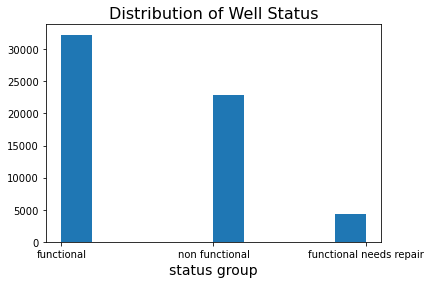

In [10]:
# Plot of the target status group

plt.hist(df_train_labels['status_group'])
plt.xlabel('status group', fontsize=14)
plt.title("Distribution of Well Status", fontsize=16)
plt.show()


Here we see a strong class imbalance that will need to be dealt with.

# Data Preparation

## Missing Values

### permit

In [11]:
df_train_set['permit'].value_counts(normalize=True,dropna=False)

True     0.654074
False    0.294478
NaN      0.051448
Name: permit, dtype: float64

In [12]:
# df_train_set.subvillage.fillna(0, inplace=True)
df_train_set.permit.fillna(0, inplace=True)
# df_train_set.public_meeting.fillna(0, inplace=True)
# df_train_set.scheme_management.fillna(0, inplace=True)

In [13]:
df_train_set['permit'].value_counts(normalize=True,dropna=False)

True     0.654074
False    0.345926
Name: permit, dtype: float64

In [14]:
#Make Permit boolean
df_train_set['permit'] = df_train_set['permit'].map(lambda x: 1 if x ==True else 0)
df_train_set['permit'].value_counts(normalize=True)

1    0.654074
0    0.345926
Name: permit, dtype: float64

### construction_year

In [15]:
# Close to 35% are zero lets replace this with the median year 2000
df_train_set['construction_year'].value_counts(normalize=True,dropna=False)

0       0.348636
2010    0.044529
2008    0.043990
2009    0.042643
2000    0.035202
2007    0.026717
2006    0.024764
2003    0.021650
2011    0.021145
2004    0.018906
2012    0.018249
2002    0.018098
1978    0.017458
1995    0.017071
2005    0.017020
1999    0.016481
1998    0.016263
1990    0.016061
1985    0.015909
1980    0.013653
1996    0.013653
1984    0.013114
1982    0.012525
1994    0.012424
1972    0.011919
1974    0.011380
1997    0.010842
1992    0.010774
1993    0.010236
2001    0.009091
1988    0.008771
1983    0.008215
1975    0.007357
1986    0.007306
1976    0.006970
1970    0.006919
1991    0.005455
1989    0.005320
1987    0.005084
1981    0.004007
1977    0.003401
1979    0.003232
1973    0.003098
2013    0.002963
1971    0.002441
1960    0.001717
1967    0.001481
1963    0.001431
1968    0.001296
1969    0.000993
1964    0.000673
1962    0.000505
1961    0.000354
1965    0.000320
1966    0.000286
Name: construction_year, dtype: float64

In [17]:
nonzero_median_year = df_train_set[ df_train_set.construction_year != 0 ].median()

In [18]:
nonzero_median_year['construction_year'] = nonzero_median_year['construction_year'].astype(int)
nonzero_median_year['construction_year']

2000.0

In [20]:
df_train_set['construction_year'].value_counts(normalize=True,dropna=False)

0       0.348636
2010    0.044529
2008    0.043990
2009    0.042643
2000    0.035202
2007    0.026717
2006    0.024764
2003    0.021650
2011    0.021145
2004    0.018906
2012    0.018249
2002    0.018098
1978    0.017458
1995    0.017071
2005    0.017020
1999    0.016481
1998    0.016263
1990    0.016061
1985    0.015909
1980    0.013653
1996    0.013653
1984    0.013114
1982    0.012525
1994    0.012424
1972    0.011919
1974    0.011380
1997    0.010842
1992    0.010774
1993    0.010236
2001    0.009091
1988    0.008771
1983    0.008215
1975    0.007357
1986    0.007306
1976    0.006970
1970    0.006919
1991    0.005455
1989    0.005320
1987    0.005084
1981    0.004007
1977    0.003401
1979    0.003232
1973    0.003098
2013    0.002963
1971    0.002441
1960    0.001717
1967    0.001481
1963    0.001431
1968    0.001296
1969    0.000993
1964    0.000673
1962    0.000505
1961    0.000354
1965    0.000320
1966    0.000286
Name: construction_year, dtype: float64

## Replace mispellings and group smaller categories


### Reformat Installer col

In [21]:
df_train_set['installer'] = df_train_set['installer'].astype(str).str.lower()
df_train_set['installer'].replace(to_replace=('0', 'nan', '-'), value='other', inplace=True)

In [22]:
df_train_set['installer'].value_counts(normalize=True)

dwe                 0.293013
other               0.074663
government          0.031835
hesawa              0.023485
rwe                 0.020303
                      ...   
kkkt ndrumangeni    0.000017
safari roya         0.000017
tsrc                0.000017
magul               0.000017
hemed abdallah      0.000017
Name: installer, Length: 1934, dtype: float64

In [23]:
df_clean=pd.read_csv('data/lookups.csv')
df_train_set = pd.merge(df_train_set, df_clean, how='left', left_on='installer', right_on='installer_old')
df_train_set.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,installer_old,installer_new
0,69572,6000.0,2011-03-14,Roman,1390,roman,34.938093,-9.856322,none,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,NaN
1,8776,0.0,2013-03-06,Grumeti,1399,grumeti,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,NaN,NaN
2,34310,25.0,2013-02-25,Lottery Club,686,world vision,37.460664,-3.821329,Kwa Mahundi,0,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,NaN,NaN
3,67743,0.0,2013-01-28,Unicef,263,unicef,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,NaN,NaN
4,19728,0.0,2011-07-13,Action In A,0,artisan,31.130847,-1.825359,Shuleni,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,NaN,NaN


In [24]:
df_train_set['installer_new'].isna().sum()

44958

In [25]:
df_train_set['installer'].value_counts(normalize=True)

dwe                 0.293013
other               0.074663
government          0.031835
hesawa              0.023485
rwe                 0.020303
                      ...   
kkkt ndrumangeni    0.000017
safari roya         0.000017
tsrc                0.000017
magul               0.000017
hemed abdallah      0.000017
Name: installer, Length: 1934, dtype: float64

In [26]:
df_train_set['installer_new'].fillna(df_train_set['installer'], inplace=True)

df_train_set

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,installer_old,installer_new
0,69572,6000.0,2011-03-14,Roman,1390,roman,34.938093,-9.856322,none,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,roman
1,8776,0.0,2013-03-06,Grumeti,1399,grumeti,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,NaN,grumeti
2,34310,25.0,2013-02-25,Lottery Club,686,world vision,37.460664,-3.821329,Kwa Mahundi,0,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,NaN,world vision
3,67743,0.0,2013-01-28,Unicef,263,unicef,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,NaN,unicef
4,19728,0.0,2011-07-13,Action In A,0,artisan,31.130847,-1.825359,Shuleni,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,NaN,artisan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,ces,37.169807,-3.253847,Area Three Namba 27,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,ces
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,NaN,cefa
59397,37057,0.0,2011-04-11,NaN,0,other,34.017087,-8.750434,Mashine,0,...,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,other,other
59398,31282,0.0,2011-03-08,Malec,0,musa,35.861315,-6.378573,Mshoro,0,...,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,NaN,musa


In [27]:
df_train_set['installer_new'].isna().sum()

0

In [28]:
df_train_set['installer_new'].value_counts(normalize=True)

dwe                           0.304983
other                         0.074663
tanzanian government          0.062323
community                     0.033266
danida                        0.028300
                                ...   
b.a.p                         0.000017
lindi contractor              0.000017
ji                            0.000017
friedkin conservation fund    0.000017
hemed abdallah                0.000017
Name: installer_new, Length: 1652, dtype: float64

In [29]:
del df_train_set['installer']
del df_train_set['installer_old']

In [30]:
df_installer_cnt = df_train_set['installer_new'].value_counts(normalize=True)
df_installer_cnt

dwe                           0.304983
other                         0.074663
tanzanian government          0.062323
community                     0.033266
danida                        0.028300
                                ...   
b.a.p                         0.000017
lindi contractor              0.000017
ji                            0.000017
friedkin conservation fund    0.000017
hemed abdallah                0.000017
Name: installer_new, Length: 1652, dtype: float64

In [31]:
df_installer_cnt.head(20)

dwe                     0.304983
other                   0.074663
tanzanian government    0.062323
community               0.033266
danida                  0.028300
hesawa                  0.023620
council                 0.022929
rwe                     0.020303
church                  0.016330
kkkt                    0.015623
finw                    0.013199
tcrs                    0.012458
world vision            0.012037
ces                     0.010269
amref                   0.007458
lga                     0.006953
tasaf                   0.006919
wedeco                  0.006700
dmdd                    0.006330
norad                   0.006162
Name: installer_new, dtype: float64

In [32]:
other_list = df_installer_cnt[df_installer_cnt<.01].index.tolist()
other_list

['amref',
 'lga',
 'tasaf',
 'wedeco',
 'dmdd',
 'norad',
 'unicef',
 'twesa',
 'da',
 'wu',
 'acra',
 'sema',
 'jaica',
 'oxfam',
 'shipo',
 'local',
 'idara ya maji',
 'villagers',
 'sengerema water department',
 'kiliwater',
 'dh',
 'kuwait',
 'distri',
 'lawatefuka water sup',
 'magadini-makiwaru wa',
 'fw',
 'private',
 'centr',
 'wvt',
 'mwe',
 'is',
 'handeni trunk main(',
 'water aid',
 'world bank',
 'wananchi',
 'rwssp',
 'jica',
 'artisan',
 'isf',
 'adra',
 'ddca',
 'african group',
 'he',
 'world',
 'tardo',
 'ir',
 'consulting engineer',
 'twe',
 'muwsa',
 'ded',
 'halmashauri ya wilaya sikonge',
 'wizara ya maji',
 'hsw',
 'go',
 'angli',
 'ki',
 'oxfarm',
 'roman',
 'vwc',
 'cefa',
 'h',
 'mdrdp',
 'aict',
 'water board',
 'region water department',
 'chamavita',
 'water',
 'lwi',
 'wa',
 'gtz',
 'mtn',
 'dawasco',
 'villa',
 'tassaf',
 'ncaa',
 'losaa-kia water supp',
 'lvia',
 'wachina',
 'wanan',
 'co',
 'rdc',
 'tlc',
 'gen',
 'dhv',
 'priva',
 'st',
 'pr',
 'cdtf',

In [33]:
df_train_set['installer_new'].replace(to_replace=other_list, value='other', inplace=True)
df_train_set['installer_new'].value_counts(normalize=True)

other                   0.424360
dwe                     0.304983
tanzanian government    0.062323
community               0.033266
danida                  0.028300
hesawa                  0.023620
council                 0.022929
rwe                     0.020303
church                  0.016330
kkkt                    0.015623
finw                    0.013199
tcrs                    0.012458
world vision            0.012037
ces                     0.010269
Name: installer_new, dtype: float64

In [34]:
df_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  wa

### Reformat Funder col

In [35]:
df_train_set['funder'] = df_train_set['funder'].astype(str).str.lower()
df_train_set['funder'].replace(to_replace=('0', 'nan', '-'), value='other', inplace=True)

In [36]:
df_train_set['funder'].value_counts(normalize=True)

government of tanzania    0.152929
other                     0.074276
danida                    0.052424
hesawa                    0.037071
rwssp                     0.023131
                            ...   
tlc/emmanuel kasoga       0.000017
villlage contributi       0.000017
hasnan murig (mbunge)     0.000017
samweli mshosha           0.000017
kajima                    0.000017
Name: funder, Length: 1897, dtype: float64

In [37]:
df_clean_funder=pd.read_csv('data/lookups_funder.csv')
df_train_set = pd.merge(df_train_set, df_clean_funder, how='left', left_on='funder', right_on='funder_old')
df_train_set.head()

,id,amount_tsh,date_recorded,funder,gps_height,longitude,latitude,wpt_name,num_private,basin,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,installer_new,funder_old,funder_new
0,69572,6000.0,2011-03-14,roman,1390,34.938093,-9.856322,none,0,Lake Nyasa,...,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,other,NaN,NaN
1,8776,0.0,2013-03-06,grumeti,1399,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,other,NaN,NaN
2,34310,25.0,2013-02-25,lottery club,686,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,world vision,NaN,NaN
3,67743,0.0,2013-01-28,unicef,263,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,other,NaN,NaN
4,19728,0.0,2011-07-13,action in a,0,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,other,NaN,NaN


In [38]:
df_train_set['funder_new'].isna().sum()

39498

In [39]:
df_train_set['funder'].value_counts(normalize=True)

government of tanzania    0.152929
other                     0.074276
danida                    0.052424
hesawa                    0.037071
rwssp                     0.023131
                            ...   
tlc/emmanuel kasoga       0.000017
villlage contributi       0.000017
hasnan murig (mbunge)     0.000017
samweli mshosha           0.000017
kajima                    0.000017
Name: funder, Length: 1897, dtype: float64

In [40]:
df_train_set['funder_new'].fillna(df_train_set['funder'], inplace=True)

df_train_set

,id,amount_tsh,date_recorded,funder,gps_height,longitude,latitude,wpt_name,num_private,basin,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,installer_new,funder_old,funder_new
0,69572,6000.0,2011-03-14,roman,1390,34.938093,-9.856322,none,0,Lake Nyasa,...,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,other,NaN,roman
1,8776,0.0,2013-03-06,grumeti,1399,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,other,NaN,grumeti
2,34310,25.0,2013-02-25,lottery club,686,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,world vision,NaN,lottery club
3,67743,0.0,2013-01-28,unicef,263,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,other,NaN,unicef
4,19728,0.0,2011-07-13,action in a,0,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,other,NaN,action in a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,germany republi,1210,37.169807,-3.253847,Area Three Namba 27,0,Pangani,...,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,ces,germany republi,german group
59396,27263,4700.0,2011-05-07,cefa-njombe,1212,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,...,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,other,NaN,cefa-njombe
59397,37057,0.0,2011-04-11,other,0,34.017087,-8.750434,Mashine,0,Rufiji,...,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,other,NaN,other
59398,31282,0.0,2011-03-08,malec,0,35.861315,-6.378573,Mshoro,0,Rufiji,...,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,other,NaN,malec


In [41]:
df_train_set['funder_new'].isna().sum()

0

In [42]:
df_train_set['funder_new'].value_counts(normalize=True)

government       0.156869
other            0.074276
danida           0.052559
hesawa           0.037323
kkkt             0.026027
                   ...   
chongolo         0.000017
lgdbg            0.000017
petro patrice    0.000017
mwakalinga       0.000017
quicklw          0.000017
Name: funder_new, Length: 1683, dtype: float64

In [43]:
del df_train_set['funder']
del df_train_set['funder_old']

In [44]:
df_installer_cnt_funder = df_train_set['funder_new'].value_counts(normalize=True)
df_installer_cnt_funder

government       0.156869
other            0.074276
danida           0.052559
hesawa           0.037323
kkkt             0.026027
                   ...   
chongolo         0.000017
lgdbg            0.000017
petro patrice    0.000017
mwakalinga       0.000017
quicklw          0.000017
Name: funder_new, Length: 1683, dtype: float64

In [45]:
df_installer_cnt_funder.head(20)

government            0.156869
other                 0.074276
danida                0.052559
hesawa                0.037323
kkkt                  0.026027
district council      0.025051
church                0.024529
rwssp                 0.023131
world bank            0.022710
world vision          0.021498
unicef                0.019798
tasaf                 0.014764
dhv                   0.013956
private individual    0.013906
dwsp                  0.013653
norad                 0.012879
finw                  0.012559
german group          0.012492
tcrs                  0.010455
ministry of water     0.009933
Name: funder_new, dtype: float64

In [46]:
other_list_funder = df_installer_cnt_funder[df_installer_cnt_funder<.01].index.tolist()
other_list_funder

['ministry of water',
 'water',
 'dwe',
 'netherlands',
 'hifab',
 'adb',
 'lga',
 'amref',
 'oxfam',
 'wateraid',
 'isf',
 'rudep',
 'private',
 'jaica',
 'roman',
 'community',
 'rural water supply and sanitat',
 'adra',
 'ces(gmbh)',
 'jica',
 'shipo',
 'wsdp',
 'dh',
 'ded',
 'plan int',
 'kiliwater',
 'dmdd',
 'go',
 'lawatefuka water supply',
 'oxfarm',
 'magadini-makiwaru water',
 'fw',
 'w.b',
 'ces (gmbh)',
 'wvt',
 'oikos e.afrika',
 'nethalan',
 'lvia',
 'concern world wide',
 'unhcr',
 'no',
 'swedish',
 'african',
 'he',
 'is',
 'ki',
 'tardo',
 'ir',
 'snv',
 'wananchi',
 'wua',
 'roman catholic',
 'bsf',
 'tassaf',
 'islamic group',
 'co',
 'lamp',
 'dfid',
 'concern',
 'muwsa',
 'villagers',
 'ru',
 'halmashauri ya wilaya sikonge',
 'hsw',
 'twe',
 'idc',
 'tanza',
 'undp',
 'mdrdp',
 'h',
 'aict',
 'gtz',
 'japan',
 'cmsr',
 'ndrdp',
 'vwc',
 'lwi',
 'kuwait',
 'caritas',
 'cdtf',
 'padep',
 'kaemp',
 'marafip',
 'water aid /sema',
 'conce',
 'cefa',
 'ncaa',
 'nationa

In [47]:
df_train_set['funder_new'].replace(to_replace=other_list_funder, value='other', inplace=True)
df_train_set['funder_new'].value_counts(normalize=True)

other                 0.485842
government            0.156869
danida                0.052559
hesawa                0.037323
kkkt                  0.026027
district council      0.025051
church                0.024529
rwssp                 0.023131
world bank            0.022710
world vision          0.021498
unicef                0.019798
tasaf                 0.014764
dhv                   0.013956
private individual    0.013906
dwsp                  0.013653
norad                 0.012879
finw                  0.012559
german group          0.012492
tcrs                  0.010455
Name: funder_new, dtype: float64

### Group Other Remaining Columns

In [48]:
def group_other(col,perc):
    df_train_set[col] = df_train_set[col].astype(str).str.lower()
    df_cnt = df_train_set[col].value_counts(normalize=True)
    other_list = df_cnt[df_cnt<perc].index.tolist()
    

    return df_train_set[col].replace(to_replace=other_list, value='other', inplace=True)
    print(df_train_set[col].value_counts(normalize=True,dropna=False))

#### lga

In [49]:
df_train_set['lga'].value_counts(normalize=True,dropna=False)

Njombe          0.042138
Arusha Rural    0.021077
Moshi Rural     0.021061
Bariadi         0.019815
Rungwe          0.018620
                  ...   
Moshi Urban     0.001330
Kigoma Urban    0.001195
Arusha Urban    0.001061
Lindi Urban     0.000354
Nyamagana       0.000017
Name: lga, Length: 125, dtype: float64

In [50]:
group_other('lga',.01)

In [51]:
df_train_set['lga'].value_counts(normalize=True,dropna=False)

other            0.475438
njombe           0.042138
arusha rural     0.021077
moshi rural      0.021061
bariadi          0.019815
rungwe           0.018620
kilosa           0.018418
kasulu           0.017626
mbozi            0.017407
meru             0.016987
bagamoyo         0.016785
singida rural    0.016751
kilombero        0.016145
same             0.014764
kibondo          0.014714
kyela            0.014461
kahama           0.014074
magu             0.013872
kigoma rural     0.013872
maswa            0.013620
karagwe          0.012980
mbinga           0.012626
iringa rural     0.012256
serengeti        0.012054
lushoto          0.011684
namtumbo         0.011684
songea rural     0.011667
mpanda           0.011431
mvomero          0.011296
ngara            0.011263
ulanga           0.011195
makete           0.010606
kwimba           0.010556
mbarali          0.010539
hai              0.010522
rombo            0.010000
Name: lga, dtype: float64

## Columns to drop

### Mostly Empty

In [52]:
df_train_set['num_private'].value_counts(normalize=True,dropna=False)

0      0.987256
6      0.001364
1      0.001229
5      0.000774
8      0.000774
         ...   
180    0.000017
213    0.000017
23     0.000017
55     0.000017
94     0.000017
Name: num_private, Length: 65, dtype: float64

### Many Individual Values

In [53]:
df_train_set['wpt_name'].value_counts(normalize=True,dropna=False)

none                         0.059983
Shuleni                      0.029428
Zahanati                     0.013973
Msikitini                    0.009007
Kanisani                     0.005438
                               ...   
Kwa Mzee Zenubius            0.000017
Msanya                       0.000017
Kwa Mbumbuli                 0.000017
Irkisale Secondary School    0.000017
Kwa Kiambae                  0.000017
Name: wpt_name, Length: 37400, dtype: float64

In [54]:
df_train_set['ward'].value_counts(normalize=True,dropna=False)

Igosi              0.005168
Imalinyi           0.004242
Siha Kati          0.003906
Mdandu             0.003889
Nduruma            0.003653
                     ...   
Uwanja wa Ndege    0.000017
Nsemulwa           0.000017
Kitete             0.000017
Linda              0.000017
Chinugulu          0.000017
Name: ward, Length: 2092, dtype: float64

### Not Significant

#### The features scheme_management, quantity_group, water_quality, region_code, payment_type, extraction_type, waterpoint_type_group, date_recorded, and recorded_by will be deleted for duplicate information.

In [55]:
def drop(df):
# Columns to drop
    df.drop([
        'scheme_management', 'quantity_group', 'water_quality', 'region', 'payment_type',
        'extraction_type', 'extraction_type_class','source','waterpoint_type_group', 'date_recorded', 'recorded_by',
        'subvillage', 'public_meeting', 'scheme_name','wpt_name','ward','num_private'],
        axis=1, inplace=True)
    return df
    

To do: look at feat importance of different geographic features remaining

- basin — Geographic water basin
- subvillage — Geographic location
- region_code — Geographic location (coded)
- district_code — Geographic location (coded)
- lga — Geographic location
- ward — Geographic location

## Categorical and Numerical

In [56]:
categorical = ['basin','region_code', 'district_code', 'lga','permit','construction_year',
               'extraction_type_group','management','management_group', 'payment', 
               'quality_group', 'quantity','source_type','source_class', 'waterpoint_type',
               'installer_new', 'funder_new']

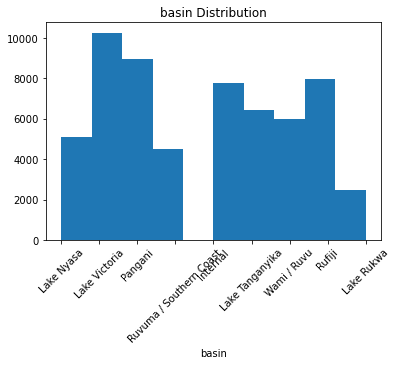

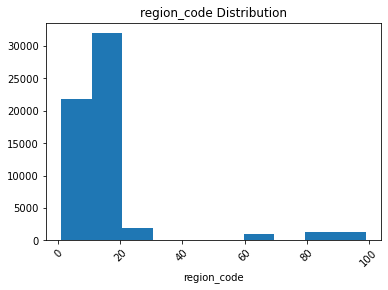

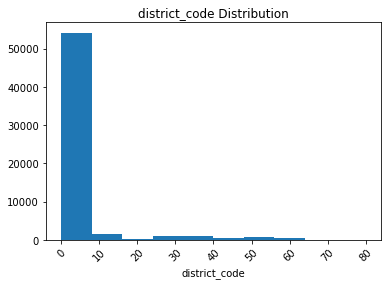

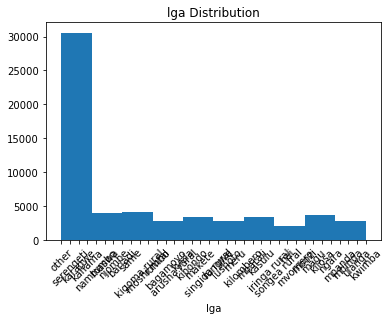

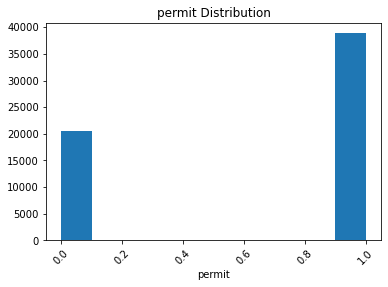

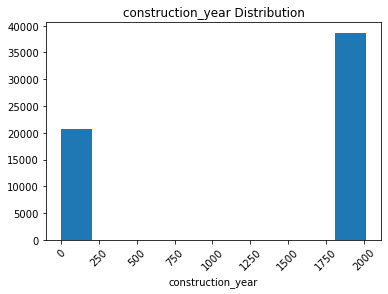

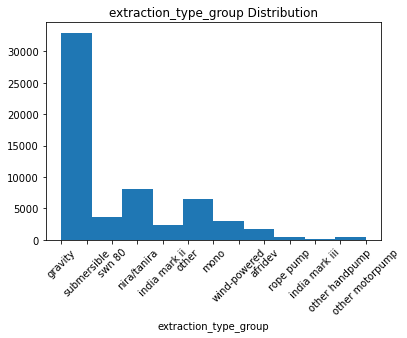

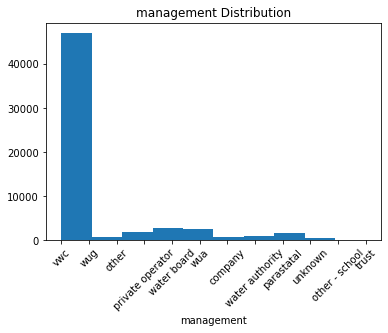

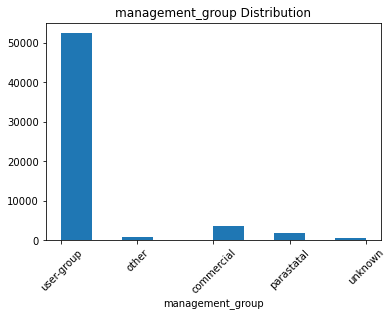

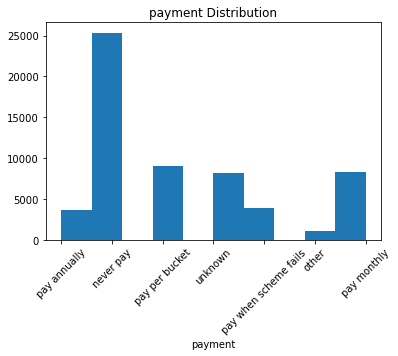

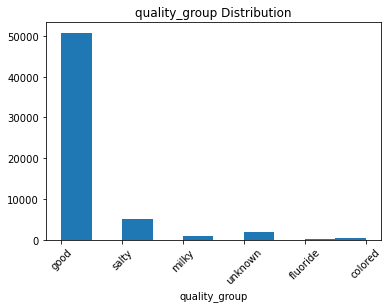

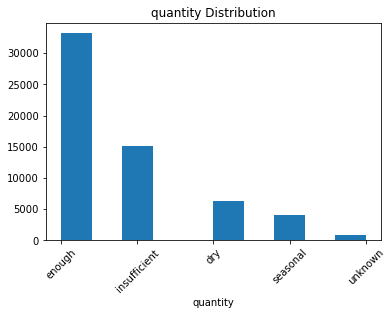

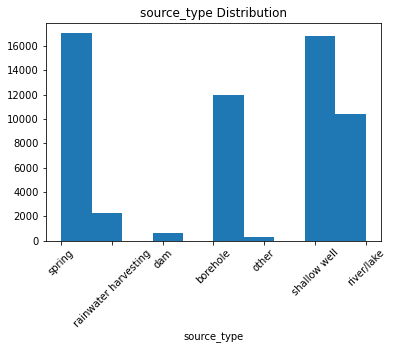

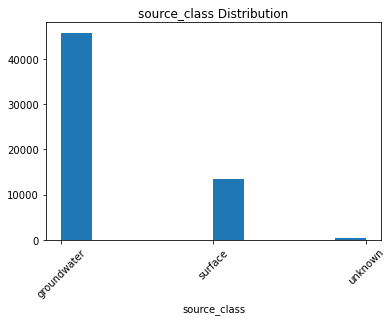

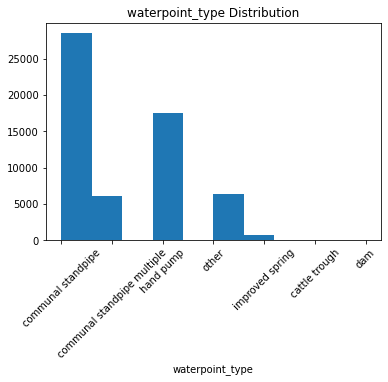

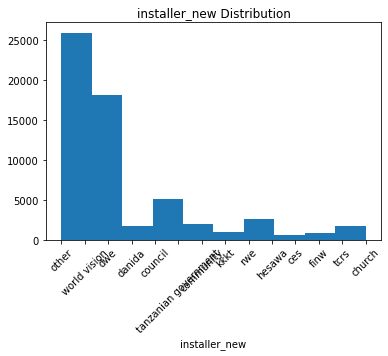

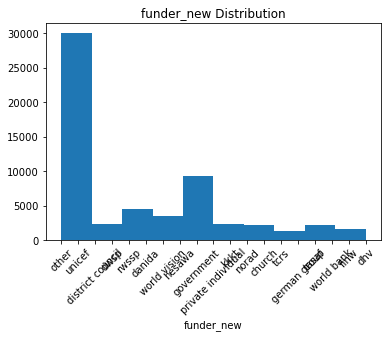

In [57]:
for column in categorical:
    plt.hist(df_train_set[column])
    plt.xlabel(column)
    plt.xticks(rotation=45)
    plt.title("{} Distribution".format(column))
    plt.show()

### Join Target: df_train_set to df_train

In [58]:
df_train = df_train_set.join(df_train_labels, on='id', how='left', lsuffix='_left', rsuffix='_right')
df_train = drop(df_train)

df_test = drop(df_test)

In [59]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_left                59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   gps_height             59400 non-null  int64  
 3   longitude              59400 non-null  float64
 4   latitude               59400 non-null  float64
 5   basin                  59400 non-null  object 
 6   region_code            59400 non-null  int64  
 7   district_code          59400 non-null  int64  
 8   lga                    59400 non-null  object 
 9   population             59400 non-null  int64  
 10  permit                 59400 non-null  int64  
 11  construction_year      59400 non-null  int64  
 12  extraction_type_group  59400 non-null  object 
 13  management             59400 non-null  object 
 14  management_group       59400 non-null  object 
 15  pa

In [60]:
df_train.columns

Index(['id_left', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'basin',
       'region_code', 'district_code', 'lga', 'population', 'permit',
       'construction_year', 'extraction_type_group', 'management',
       'management_group', 'payment', 'quality_group', 'quantity',
       'source_type', 'source_class', 'waterpoint_type', 'installer_new',
       'funder_new', 'id_right', 'status_group'],
      dtype='object')

In [61]:
df_train['status_group'].value_counts(normalize=True,dropna=False)

functional                 0.436229
non functional             0.305522
NaN                        0.200471
functional needs repair    0.057778
Name: status_group, dtype: float64

In [62]:
numerical = ['amount_tsh','gps_height','population']

In [63]:
numerical_large = ['gps_height','population']

In [64]:
numerical_small = ['amount_tsh']

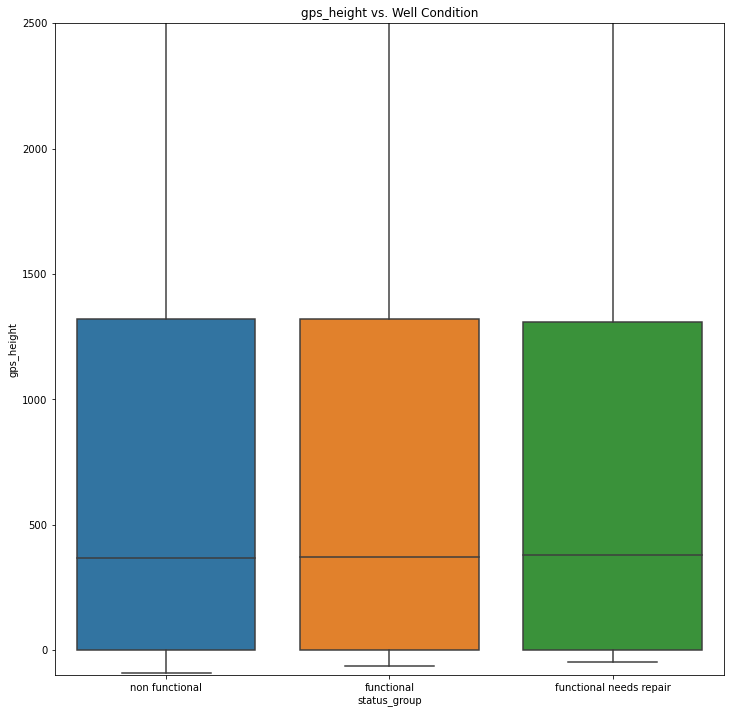

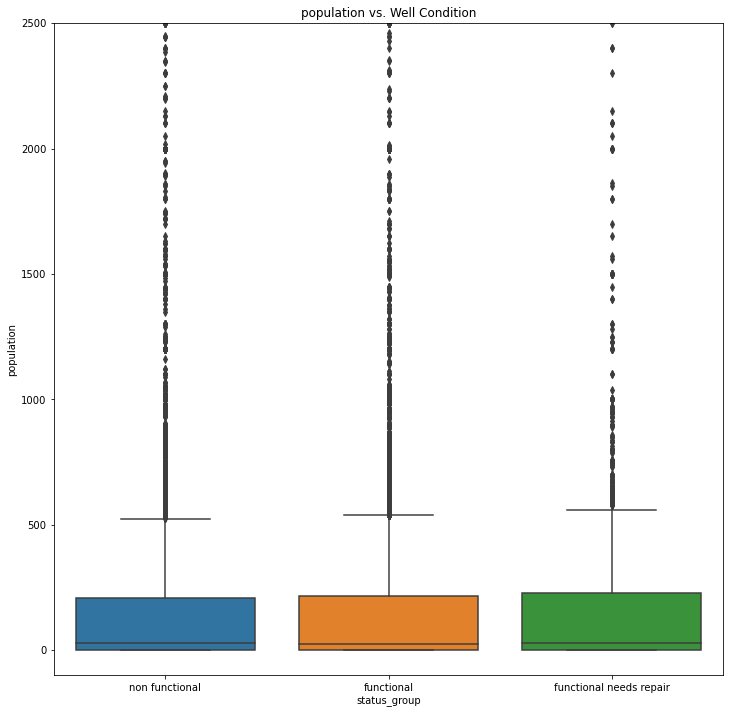

In [65]:
for variable in numerical_large:
    ax, figure = plt.subplots(1,1,figsize=(12,12))
    plt.ylim(-100,2500)
    sns.boxplot(x='status_group', y=variable, data=df_train)
    plt.title("{} vs. Well Condition".format(variable))

In [66]:
del df_train['gps_height']
del df_train['population']

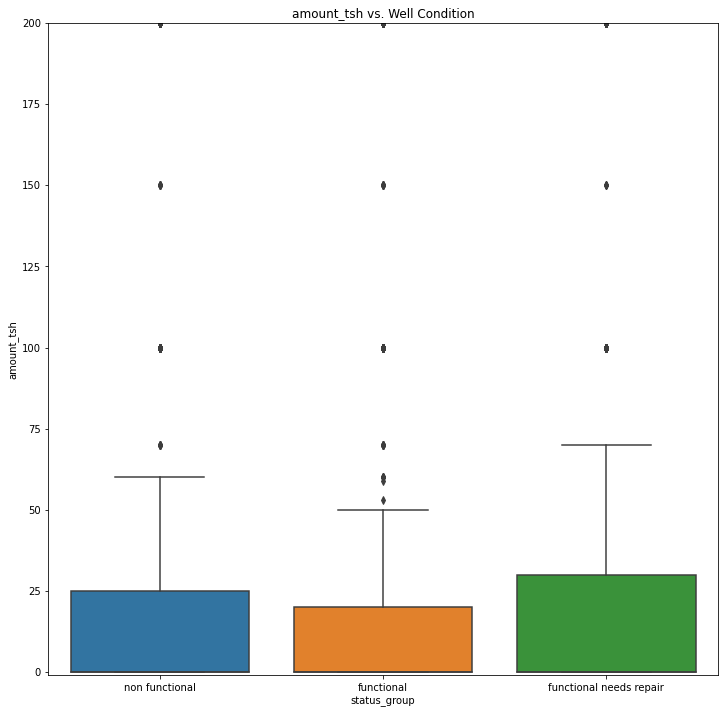

In [67]:
for variable in numerical_small:
    ax, figure = plt.subplots(1,1,figsize=(12,12))
    plt.ylim(-1,200)
    sns.boxplot(x='status_group', y=variable, data=df_train)
    plt.title("{} vs. Well Condition".format(variable))

### Column Binning

In [68]:
year_plot = ['construction_year']

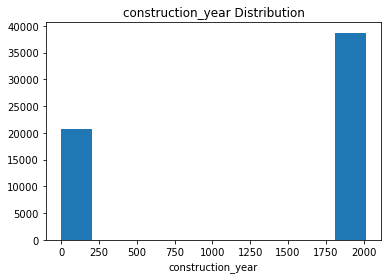

In [69]:
for column in year_plot:
    plt.hist(df_train[column])
    plt.xlabel(column)
    plt.title("{} Distribution".format(column))
    plt.show()

In [70]:
bin_features = ['amount_tsh','construction_year']

In [71]:
df_train['construction_year'].value_counts(normalize=True,dropna=False)

0       0.348636
2010    0.044529
2008    0.043990
2009    0.042643
2000    0.035202
2007    0.026717
2006    0.024764
2003    0.021650
2011    0.021145
2004    0.018906
2012    0.018249
2002    0.018098
1978    0.017458
1995    0.017071
2005    0.017020
1999    0.016481
1998    0.016263
1990    0.016061
1985    0.015909
1980    0.013653
1996    0.013653
1984    0.013114
1982    0.012525
1994    0.012424
1972    0.011919
1974    0.011380
1997    0.010842
1992    0.010774
1993    0.010236
2001    0.009091
1988    0.008771
1983    0.008215
1975    0.007357
1986    0.007306
1976    0.006970
1970    0.006919
1991    0.005455
1989    0.005320
1987    0.005084
1981    0.004007
1977    0.003401
1979    0.003232
1973    0.003098
2013    0.002963
1971    0.002441
1960    0.001717
1967    0.001481
1963    0.001431
1968    0.001296
1969    0.000993
1964    0.000673
1962    0.000505
1961    0.000354
1965    0.000320
1966    0.000286
Name: construction_year, dtype: float64

In [72]:
df_train['amount_tsh'].value_counts(normalize=True,dropna=False)

0.0         0.700993
500.0       0.052222
50.0        0.041616
1000.0      0.025051
20.0        0.024630
              ...   
8500.0      0.000017
6300.0      0.000017
220.0       0.000017
138000.0    0.000017
12.0        0.000017
Name: amount_tsh, Length: 98, dtype: float64

In [73]:
df_train.amount_tsh.fillna(0, inplace=True)

In [74]:
# and we will also take a look at their summary statistics
for feat in bin_features:
    print(df_train[feat].describe())


count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64
count    59400.000000
mean      1300.652475
std        951.620547
min          0.000000
25%          0.000000
50%       1986.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64


In [75]:
# based on some intuition and the quantile distributions, we will define our bin ranges.
tsh_bins = [-1,0,20,350000]
construction_year_bins = [0,1,1985,2005,2015]

In [76]:
# now lets convert these columns to binned categories
# note that when binning these, the default setting is that the values on the right are included in the bin

df_train['amount_tsh'] = pd.cut(df_train['amount_tsh'], tsh_bins)
df_train['construction_year'] = pd.cut(df_train['construction_year'], construction_year_bins)

In [77]:
# and we will also take a look at the distribution across bins 
for feat in bin_features:
    print(df_train[feat].value_counts(normalize=True, dropna=False))

(-1, 0]         0.700993
(20, 350000]    0.249495
(0, 20]         0.049512
Name: amount_tsh, dtype: float64
NaN                 0.348636
(1985.0, 2005.0]    0.275707
(2005.0, 2015.0]    0.225000
(1.0, 1985.0]       0.150657
(0.0, 1.0]          0.000000
Name: construction_year, dtype: float64


In [78]:
df_train['amount_tsh'].value_counts(normalize=True, dropna=False)

(-1, 0]         0.700993
(20, 350000]    0.249495
(0, 20]         0.049512
Name: amount_tsh, dtype: float64

In [79]:
df_train['amount_tsh']

0        (20, 350000]
1             (-1, 0]
2        (20, 350000]
3             (-1, 0]
4             (-1, 0]
             ...     
59395         (0, 20]
59396    (20, 350000]
59397         (-1, 0]
59398         (-1, 0]
59399         (-1, 0]
Name: amount_tsh, Length: 59400, dtype: category
Categories (3, interval[int64]): [(-1, 0] < (0, 20] < (20, 350000]]

In [80]:
df_train['amount_tsh'].value_counts(normalize=True, dropna=False)

(-1, 0]         0.700993
(20, 350000]    0.249495
(0, 20]         0.049512
Name: amount_tsh, dtype: float64

In [81]:
df_train.columns

Index(['id_left', 'amount_tsh', 'longitude', 'latitude', 'basin',
       'region_code', 'district_code', 'lga', 'permit', 'construction_year',
       'extraction_type_group', 'management', 'management_group', 'payment',
       'quality_group', 'quantity', 'source_type', 'source_class',
       'waterpoint_type', 'installer_new', 'funder_new', 'id_right',
       'status_group'],
      dtype='object')

### Clean Target

In [82]:
df_train['status_group'].value_counts(normalize=True, dropna=False)

functional                 0.436229
non functional             0.305522
NaN                        0.200471
functional needs repair    0.057778
Name: status_group, dtype: float64

In [83]:
df_train.status_group.fillna(0, inplace=True)

In [84]:
df_train['status_group'].value_counts(normalize=True, dropna=False)

functional                 0.436229
non functional             0.305522
0                          0.200471
functional needs repair    0.057778
Name: status_group, dtype: float64

In [85]:
# delte rows where prediction values did not join
df_train = df_train[df_train.status_group != 0]

### Visualizations

In [184]:
df_train['status_group_2'] = df_train['status_group']
di = {'functional': 'functional', 'non functional': 'non functional', 'functional needs repair':'functional' }
df_train['status_group_2'].replace(di, inplace=True)

In [191]:
# creating a list
visuals = df_train.columns
  
# items to be removed
unwanted_ele = ['id_left','longitude','latitude','id_right','status_group', 'status_group_2']
  
visuals = [ele for ele in visuals if ele not in unwanted_ele]

status_group_2,functional,non functional
amount_tsh,,
"(-1, 0]",61.970517,38.029483
"(0, 20]",59.991568,40.008432
"(20, 350000]",61.632997,38.367003


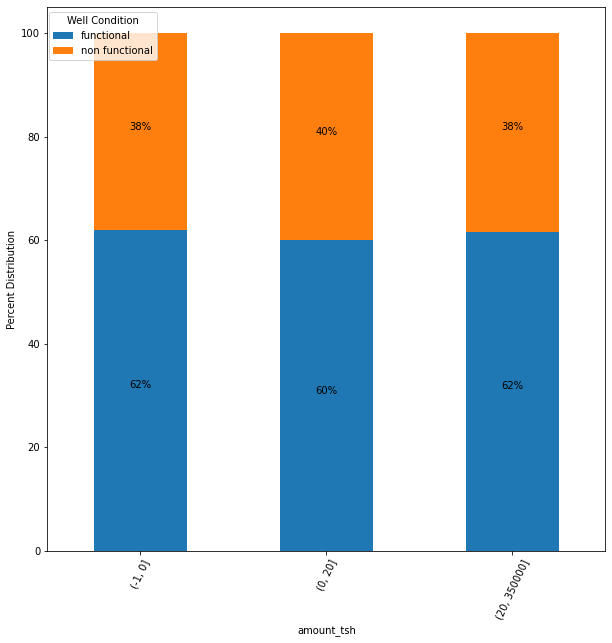

status_group_2,functional,non functional
basin,,
Internal,61.193791,38.806209
Lake Nyasa,63.015051,36.984949
Lake Rukwa,62.303399,37.696601
Lake Tanganyika,61.556196,38.443804
Lake Victoria,61.842430,38.157570
Pangani,61.172366,38.827634
Rufiji,62.500000,37.500000
Ruvuma / Southern Coast,61.974201,38.025799
Wami / Ruvu,61.297726,38.702274


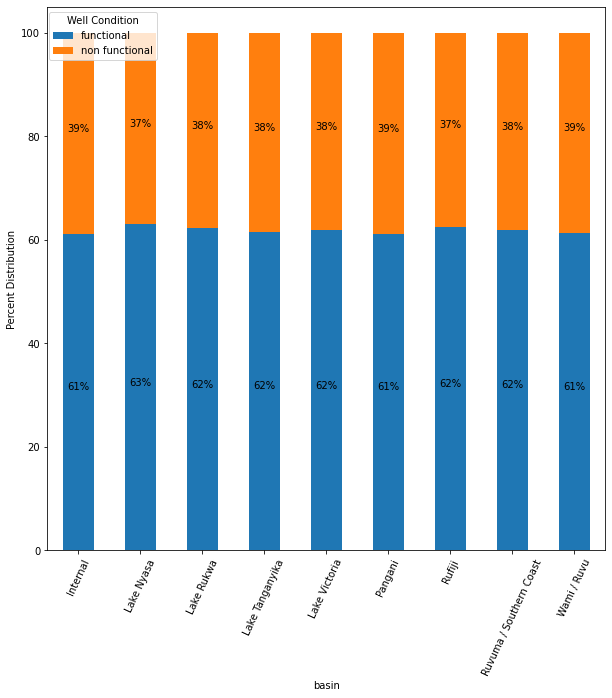

status_group_2,functional,non functional
region_code,,
1,62.971300,37.028700
2,61.972984,38.027016
3,61.425697,38.574303
4,59.901235,40.098765
5,61.406250,38.593750
6,60.186625,39.813375
7,64.050235,35.949765
8,63.043478,36.956522
9,63.398693,36.601307


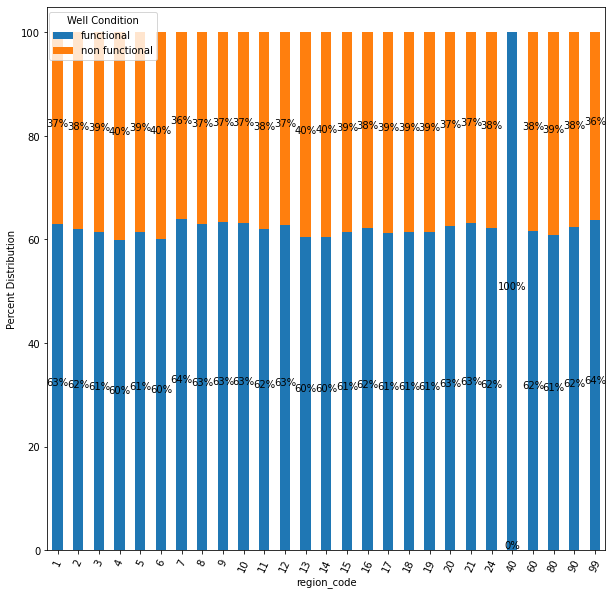

status_group_2,functional,non functional
district_code,,
0,57.894737,42.105263
1,61.451364,38.548636
2,61.708264,38.291736
3,61.499937,38.500063
4,61.970457,38.029543
5,61.863676,38.136324
6,63.017934,36.982066
7,62.668666,37.331334
8,61.547763,38.452237


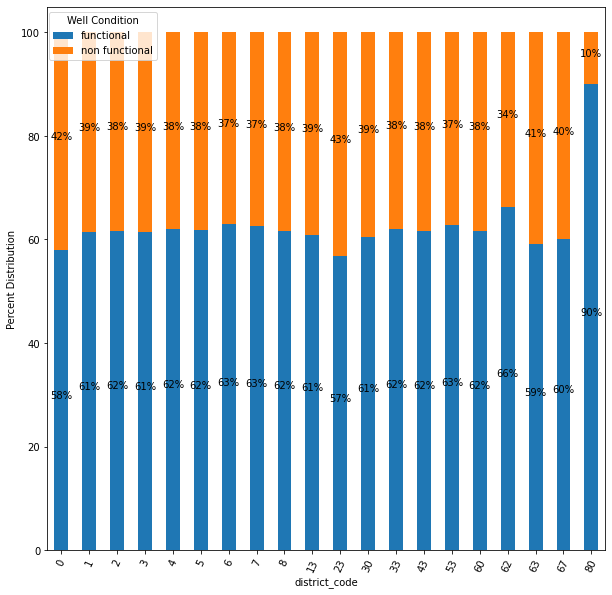

status_group_2,functional,non functional
lga,,
arusha rural,61.001965,38.998035
bagamoyo,59.898477,40.101523
bariadi,62.291667,37.708333
hai,60.279441,39.720559
iringa rural,61.658031,38.341969
kahama,61.516035,38.483965
karagwe,60.396040,39.603960
kasulu,62.571757,37.428243
kibondo,61.756374,38.243626


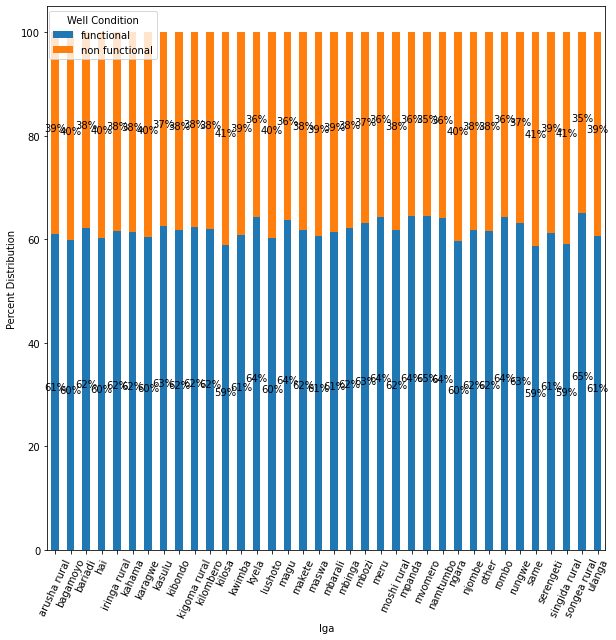

status_group_2,functional,non functional
permit,,
0,61.340803,38.659197
1,62.023239,37.976761


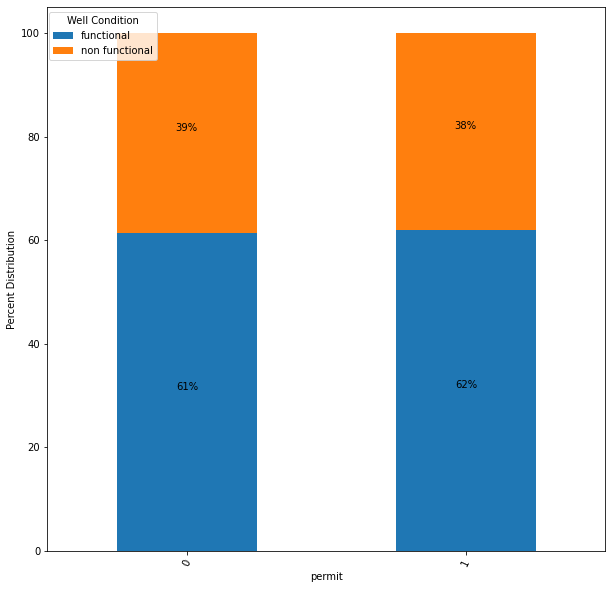

status_group_2,functional,non functional
construction_year,,
"(1, 1985]",61.038961,38.961039
"(1985, 2005]",62.112891,37.887109
"(2005, 2015]",61.928792,38.071208


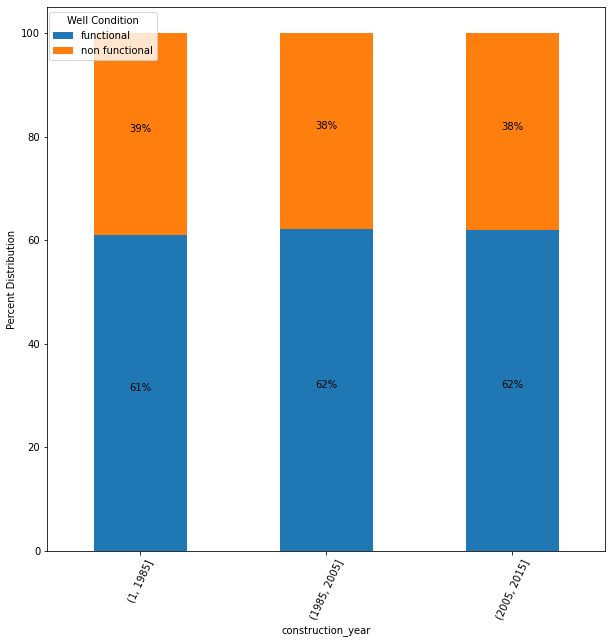

status_group_2,functional,non functional
extraction_type_group,,
afridev,61.337209,38.662791
gravity,61.879847,38.120153
india mark ii,63.216561,36.783439
india mark iii,63.291139,36.708861
mono,59.877889,40.122111
nira/tanira,61.896080,38.103920
other,62.205485,37.794515
other handpump,56.944444,43.055556
other motorpump,65.686275,34.313725


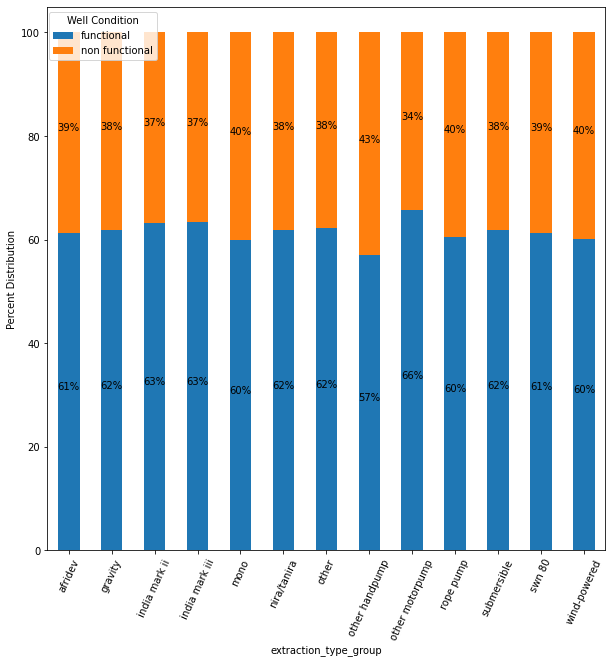

status_group_2,functional,non functional
management,,
company,62.927757,37.072243
other,60.514372,39.485628
other - school,59.259259,40.740741
parastatal,61.935484,38.064516
private operator,62.570533,37.429467
trust,71.428571,28.571429
unknown,62.800875,37.199125
vwc,61.797232,38.202768
water authority,63.210227,36.789773


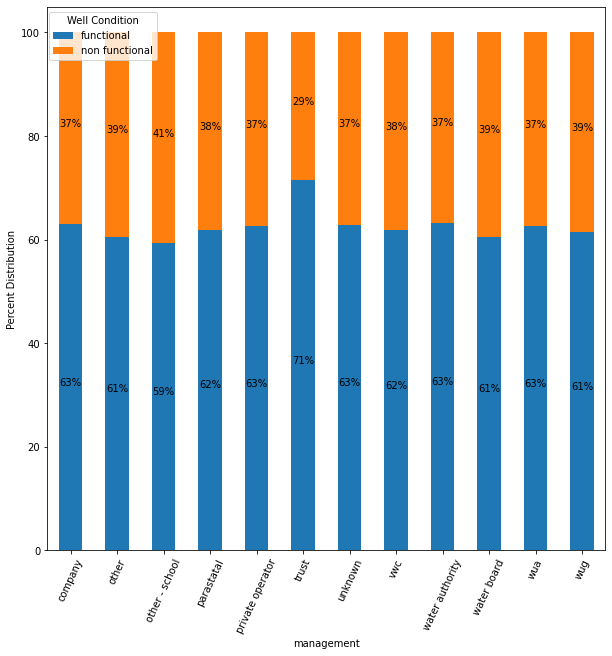

status_group_2,functional,non functional
management_group,,
commercial,62.984765,37.015235
other,60.377358,39.622642
parastatal,61.935484,38.064516
unknown,62.800875,37.199125
user-group,61.713878,38.286122


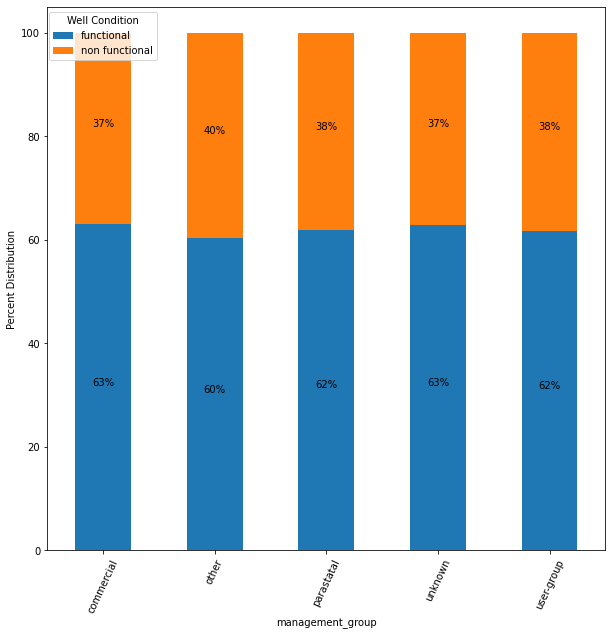

status_group_2,functional,non functional
payment,,
never pay,62.149209,37.850791
other,59.047619,40.952381
pay annually,62.555518,37.444482
pay monthly,61.691843,38.308157
pay per bucket,60.711320,39.288680
pay when scheme fails,62.109624,37.890376
unknown,61.805876,38.194124


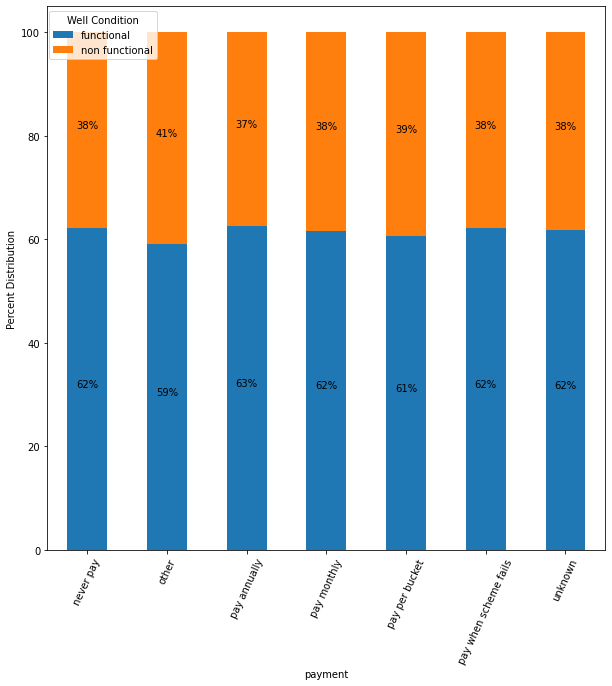

status_group_2,functional,non functional
quality_group,,
colored,59.438776,40.561224
fluoride,66.272189,33.727811
good,61.825869,38.174131
milky,61.633282,38.366718
salty,61.460102,38.539898
unknown,61.814489,38.185511


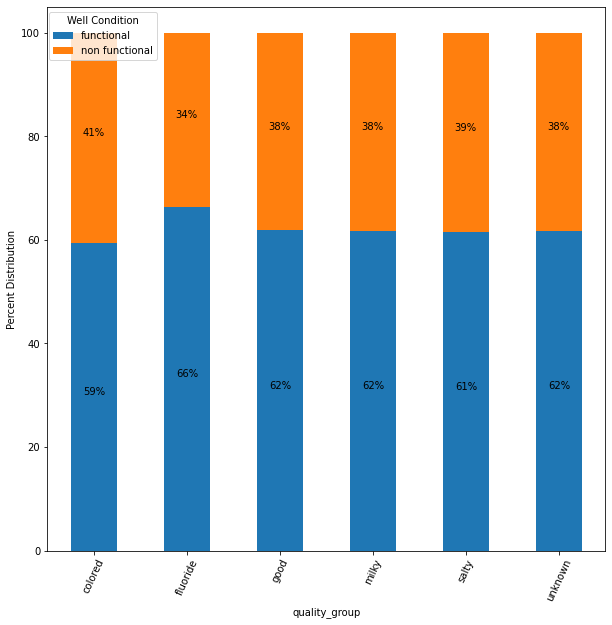

status_group_2,functional,non functional
quantity,,
dry,62.157842,37.842158
enough,61.767147,38.232853
insufficient,61.736547,38.263453
seasonal,61.816497,38.183503
unknown,60.509554,39.490446


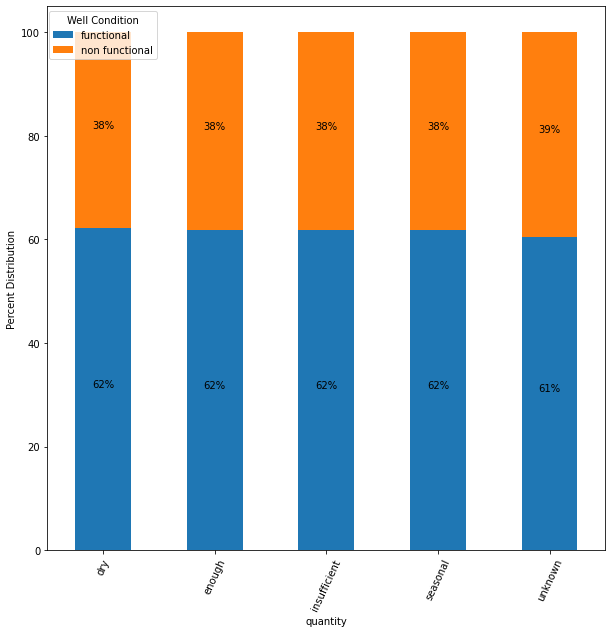

status_group_2,functional,non functional
source_type,,
borehole,60.901147,39.098853
dam,59.701493,40.298507
other,63.551402,36.448598
rainwater harvesting,61.928105,38.071895
river/lake,61.815786,38.184214
shallow well,62.152546,37.847454
spring,62.062357,37.937643


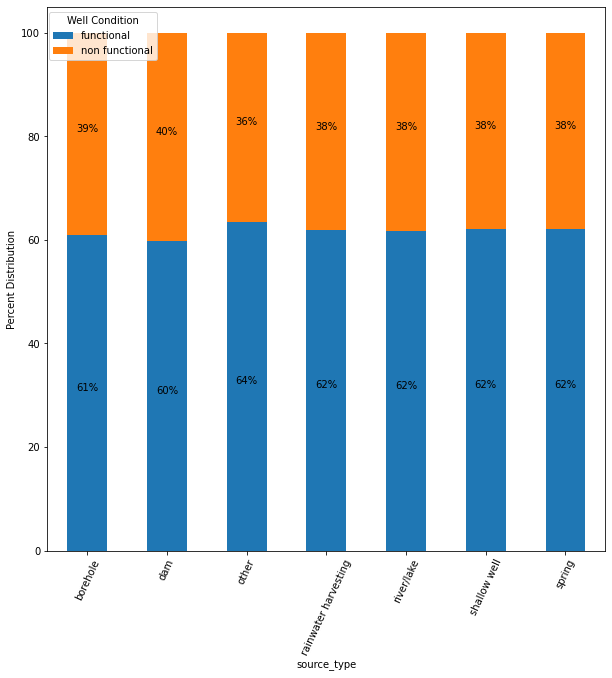

status_group_2,functional,non functional
source_class,,
groundwater,61.793911,38.206089
surface,61.729316,38.270684
unknown,63.551402,36.448598


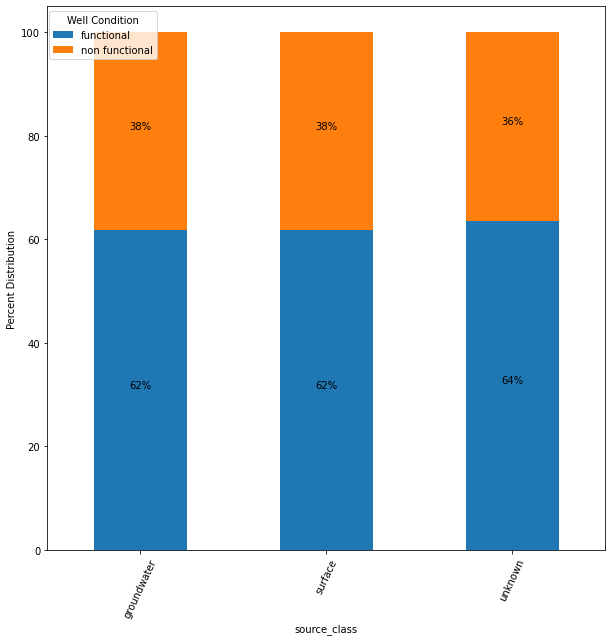

status_group_2,functional,non functional
waterpoint_type,,
cattle trough,65.168539,34.831461
communal standpipe,61.835240,38.164760
communal standpipe multiple,60.998152,39.001848
dam,50.000000,50.000000
hand pump,61.749300,38.250700
improved spring,60.919540,39.080460
other,62.478252,37.521748


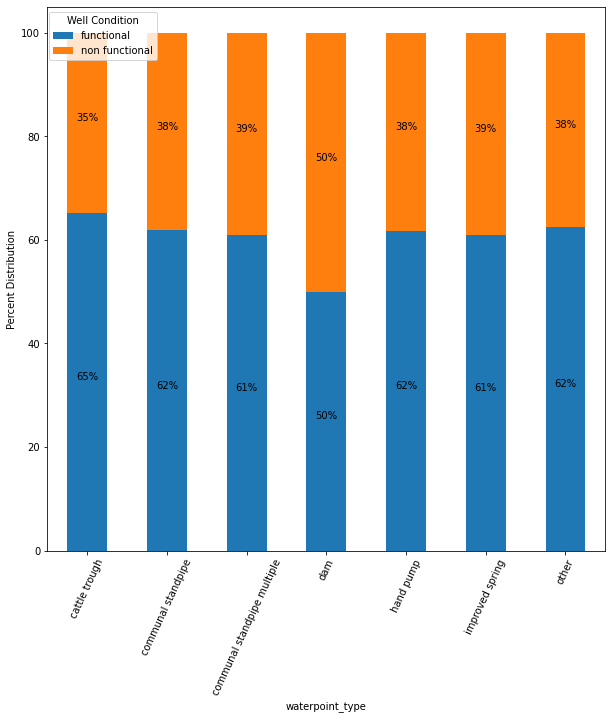

status_group_2,functional,non functional
installer_new,,
ces,60.081466,39.918534
church,63.832487,36.167513
community,62.712934,37.287066
council,61.580882,38.419118
danida,61.851016,38.148984
dwe,61.184798,38.815202
finw,64.912281,35.087719
hesawa,63.057325,36.942675
kkkt,64.792503,35.207497


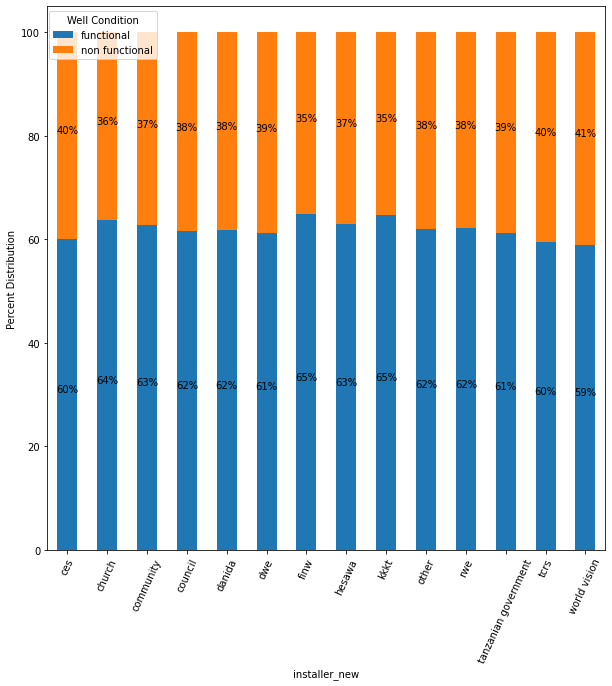

status_group_2,functional,non functional
funder_new,,
church,62.542373,37.457627
danida,61.690141,38.309859
dhv,60.856269,39.143731
district council,61.441744,38.558256
dwsp,61.290323,38.709677
finw,64.072848,35.927152
german group,60.601002,39.398998
government,61.460856,38.539144
hesawa,63.667426,36.332574


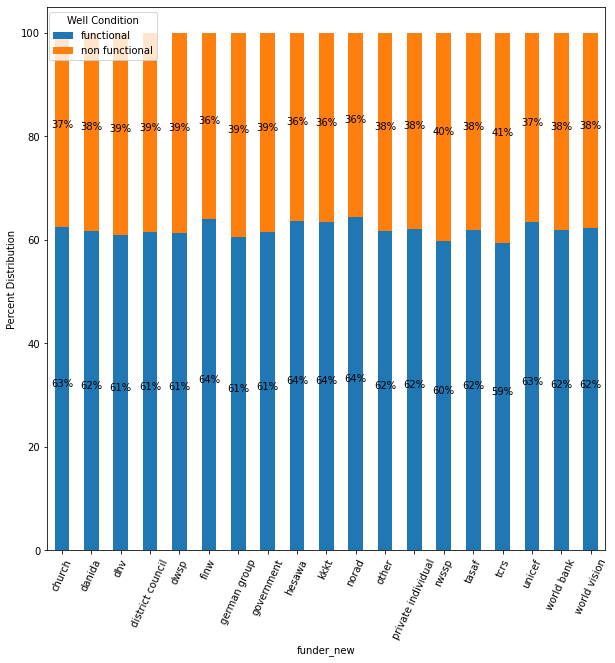

In [198]:
for column in visuals:
    ax= pd.crosstab(df_train[column], df_train['status_group_2']).apply(lambda r: r/r.sum()*100, axis=1)
    ax_1 = ax.plot.bar(figsize=(10,10),stacked=True, rot=0)
    display(ax)
    plt.legend(loc='upper center', bbox_to_anchor=(0.1, 1.0), title='Well Condition')
    plt.xlabel(column)
    plt.xticks(rotation=65)
    plt.ylabel('Percent Distribution')
    
    for rec in ax_1.patches:
        height = rec.get_height()
        ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')
    plt.show()

status_group,functional,functional needs repair,non functional
amount_tsh,,,
"(-1, 0]",54.870638,7.099880,38.029483
"(0, 20]",52.403035,7.588533,40.008432
"(20, 350000]",54.124579,7.508418,38.367003


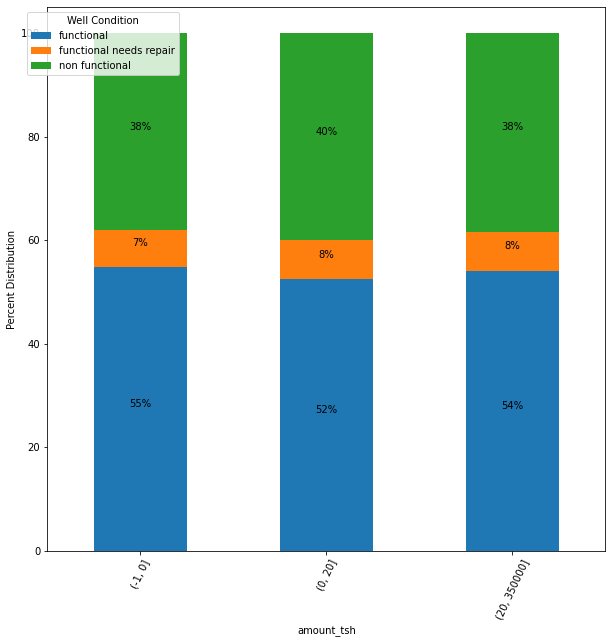

status_group,functional,functional needs repair,non functional
basin,,,
Internal,54.680749,6.513042,38.806209
Lake Nyasa,55.539107,7.475944,36.984949
Lake Rukwa,54.997463,7.305936,37.696601
Lake Tanganyika,54.197887,7.358309,38.443804
Lake Victoria,54.816004,7.026426,38.157570
Pangani,53.635729,7.536636,38.827634
Rufiji,55.428661,7.071339,37.500000
Ruvuma / Southern Coast,54.627033,7.347168,38.025799
Wami / Ruvu,53.536407,7.761319,38.702274


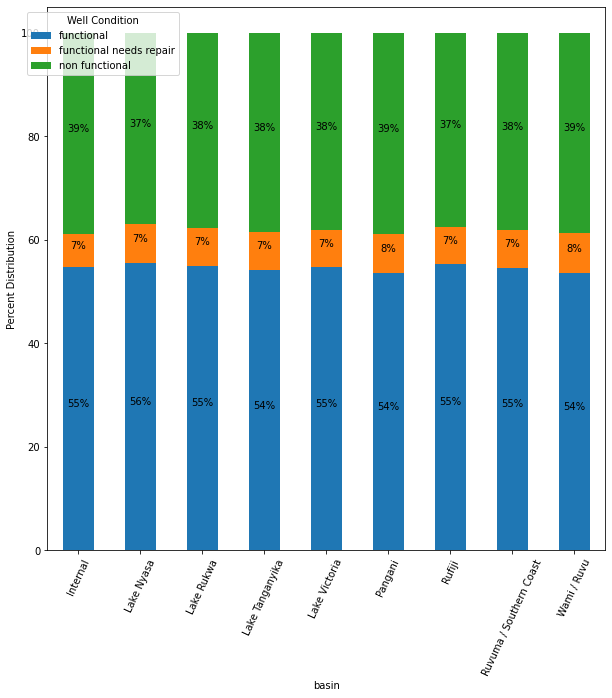

status_group,functional,functional needs repair,non functional
region_code,,,
1,56.049522,6.921778,37.028700
2,55.259926,6.713058,38.027016
3,54.067261,7.358436,38.574303
4,52.000000,7.901235,40.098765
5,53.875000,7.531250,38.593750
6,53.343701,6.842924,39.813375
7,56.357928,7.692308,35.949765
8,55.652174,7.391304,36.956522
9,56.535948,6.862745,36.601307


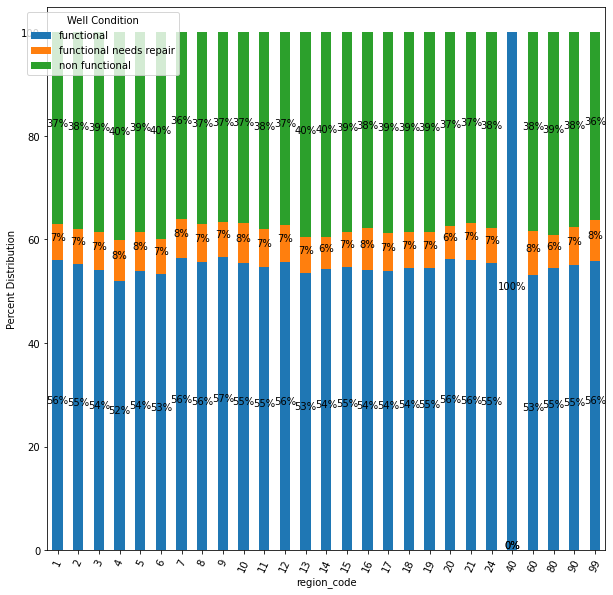

status_group,functional,functional needs repair,non functional
district_code,,,
0,47.368421,10.526316,42.105263
1,54.194545,7.256819,38.548636
2,54.453688,7.254576,38.291736
3,54.087893,7.412045,38.500063
4,55.156076,6.814381,38.029543
5,54.299684,7.563992,38.136324
6,55.720470,7.297464,36.982066
7,55.584708,7.083958,37.331334
8,54.292624,7.255139,38.452237


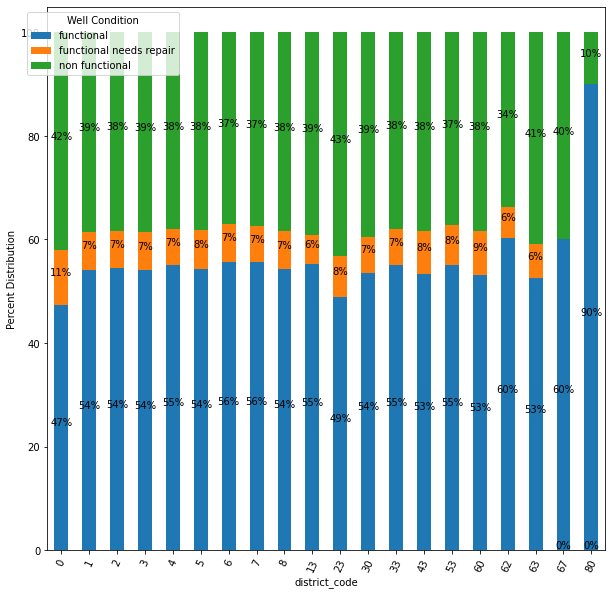

status_group,functional,functional needs repair,non functional
lga,,,
arusha rural,54.322200,6.679764,38.998035
bagamoyo,52.918782,6.979695,40.101523
bariadi,53.645833,8.645833,37.708333
hai,51.097804,9.181637,39.720559
iringa rural,55.440415,6.217617,38.341969
kahama,53.935860,7.580175,38.483965
karagwe,52.475248,7.920792,39.603960
kasulu,53.960964,8.610792,37.428243
kibondo,54.107649,7.648725,38.243626


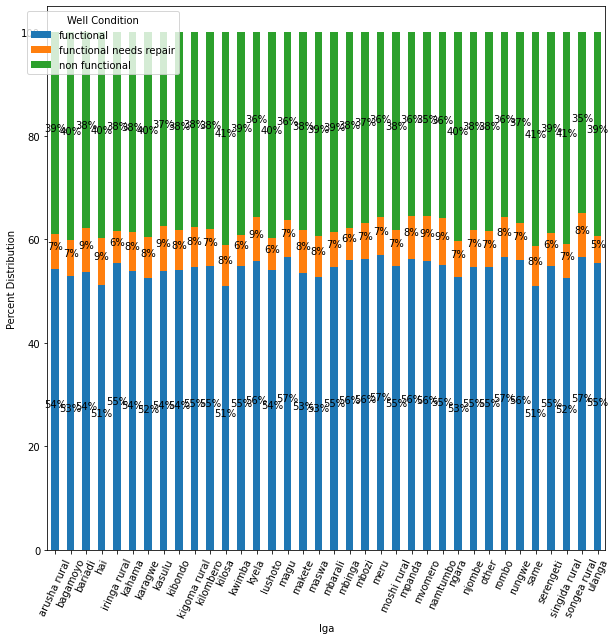

status_group,functional,functional needs repair,non functional
permit,,,
0,54.058333,7.282470,38.659197
1,54.826354,7.196884,37.976761


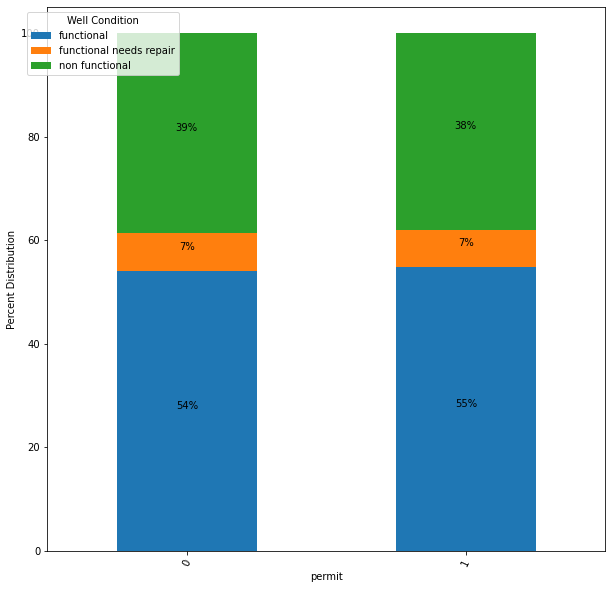

status_group,functional,functional needs repair,non functional
construction_year,,,
"(1, 1985]",53.917051,7.121910,38.961039
"(1985, 2005]",54.630053,7.482838,37.887109
"(2005, 2015]",54.686478,7.242314,38.071208


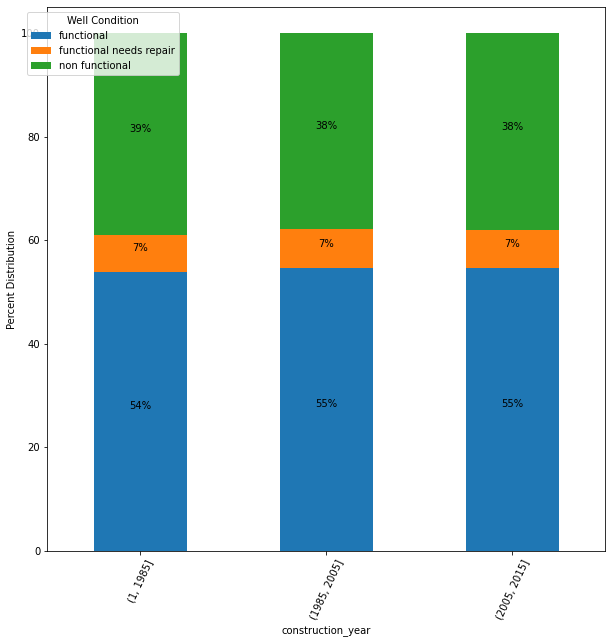

status_group,functional,functional needs repair,non functional
extraction_type_group,,,
afridev,54.578488,6.758721,38.662791
gravity,54.638886,7.240960,38.120153
india mark ii,55.095541,8.121019,36.783439
india mark iii,58.227848,5.063291,36.708861
mono,53.161797,6.716092,40.122111
nira/tanira,54.679429,7.216651,38.103920
other,55.001931,7.203553,37.794515
other handpump,50.694444,6.250000,43.055556
other motorpump,60.784314,4.901961,34.313725


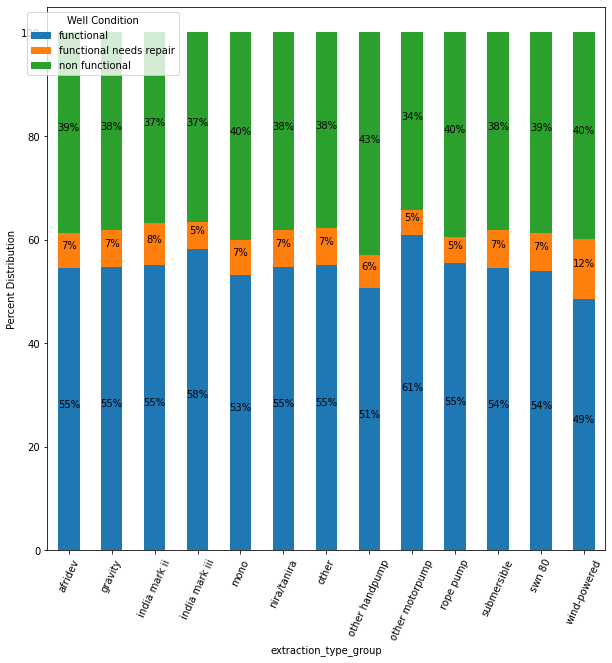

status_group,functional,functional needs repair,non functional
management,,,
company,55.513308,7.414449,37.072243
other,53.857791,6.656581,39.485628
other - school,53.086420,6.172840,40.740741
parastatal,54.121864,7.813620,38.064516
private operator,55.172414,7.398119,37.429467
trust,60.317460,11.111111,28.571429
unknown,56.455142,6.345733,37.199125
vwc,54.605832,7.191400,38.202768
water authority,55.397727,7.812500,36.789773


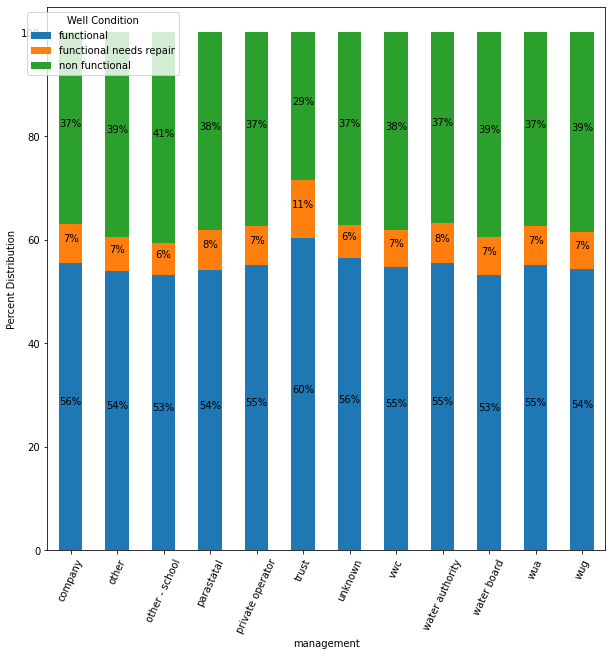

status_group,functional,functional needs repair,non functional
management_group,,,
commercial,55.401662,7.583102,37.015235
other,53.773585,6.603774,39.622642
parastatal,54.121864,7.813620,38.064516
unknown,56.455142,6.345733,37.199125
user-group,54.510831,7.203047,38.286122


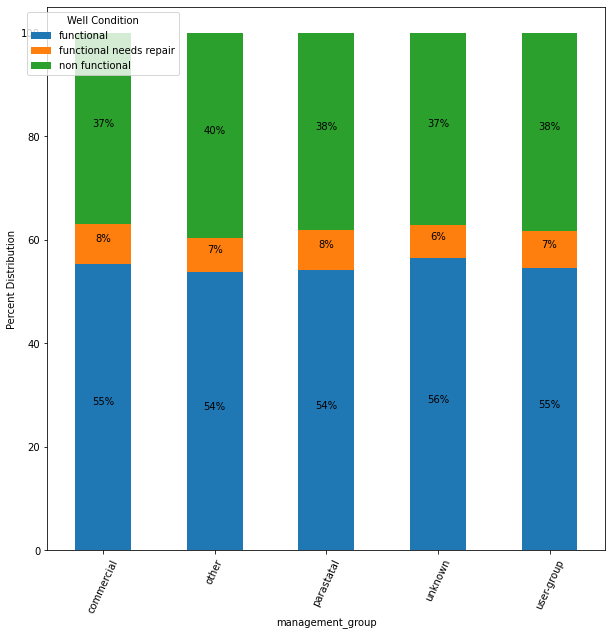

status_group,functional,functional needs repair,non functional
payment,,,
never pay,54.960474,7.188735,37.850791
other,50.833333,8.214286,40.952381
pay annually,55.107619,7.447899,37.444482
pay monthly,54.108761,7.583082,38.308157
pay per bucket,53.432051,7.279269,39.288680
pay when scheme fails,55.544933,6.564691,37.890376
unknown,54.791571,7.014305,38.194124


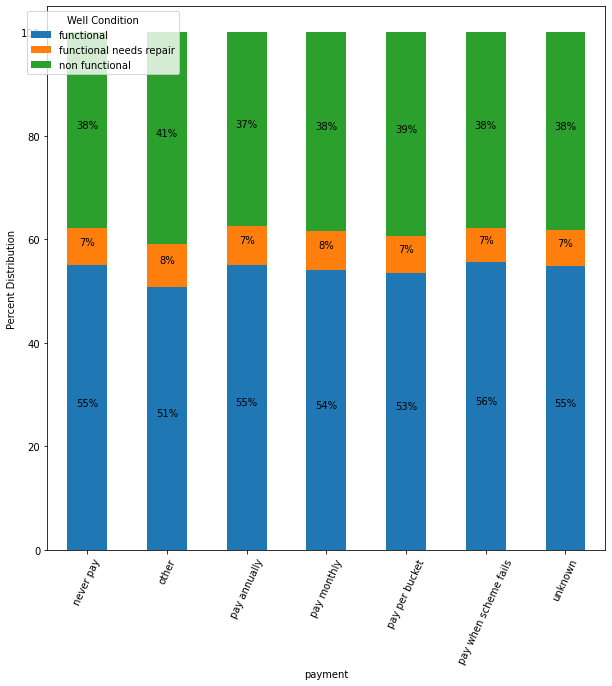

status_group,functional,functional needs repair,non functional
quality_group,,,
colored,52.806122,6.632653,40.561224
fluoride,59.171598,7.100592,33.727811
good,54.655622,7.170247,38.174131
milky,53.312789,8.320493,38.366718
salty,54.111084,7.349018,38.539898
unknown,53.689912,8.124577,38.185511


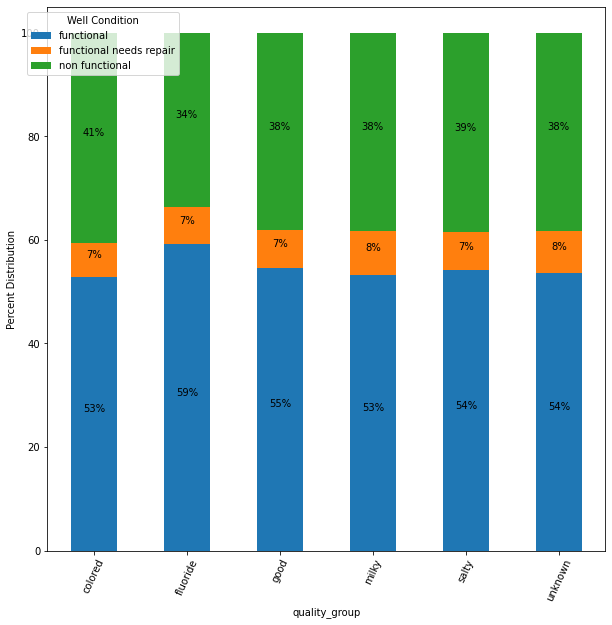

status_group,functional,functional needs repair,non functional
quantity,,,
dry,54.525475,7.632368,37.842158
enough,54.659322,7.107825,38.232853
insufficient,54.547706,7.188841,38.263453
seasonal,54.371331,7.445165,38.183503
unknown,51.910828,8.598726,39.490446


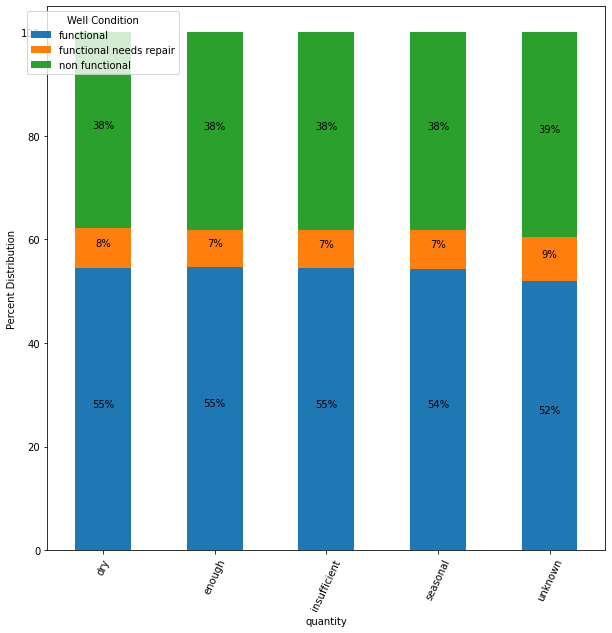

status_group,functional,functional needs repair,non functional
source_type,,,
borehole,53.900411,7.000737,39.098853
dam,52.798507,6.902985,40.298507
other,54.672897,8.878505,36.448598
rainwater harvesting,54.793028,7.135076,38.071895
river/lake,54.545455,7.270332,38.184214
shallow well,54.792084,7.360463,37.847454
spring,54.838947,7.223410,37.937643


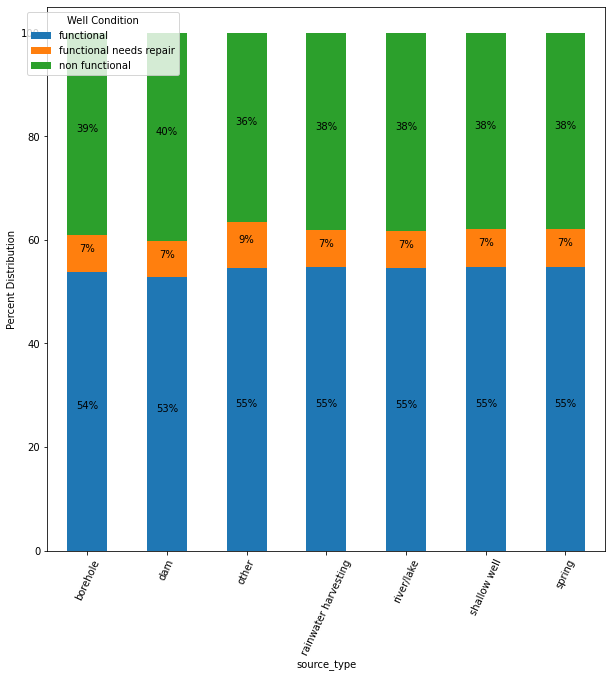

status_group,functional,functional needs repair,non functional
source_class,,,
groundwater,54.577783,7.216128,38.206089
surface,54.500513,7.228803,38.270684
unknown,54.672897,8.878505,36.448598


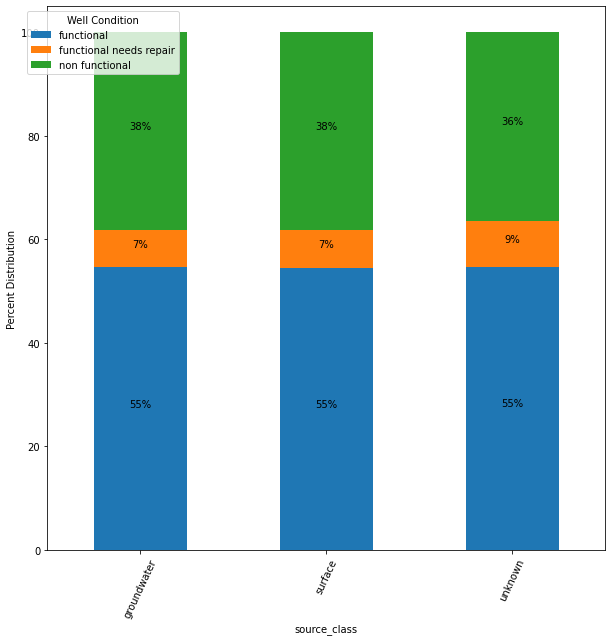

status_group,functional,functional needs repair,non functional
waterpoint_type,,,
cattle trough,59.550562,5.617978,34.831461
communal standpipe,54.522338,7.312903,38.164760
communal standpipe multiple,53.686589,7.311563,39.001848
dam,50.000000,0.000000,50.000000
hand pump,54.502404,7.246897,38.250700
improved spring,55.172414,5.747126,39.080460
other,55.557703,6.920549,37.521748


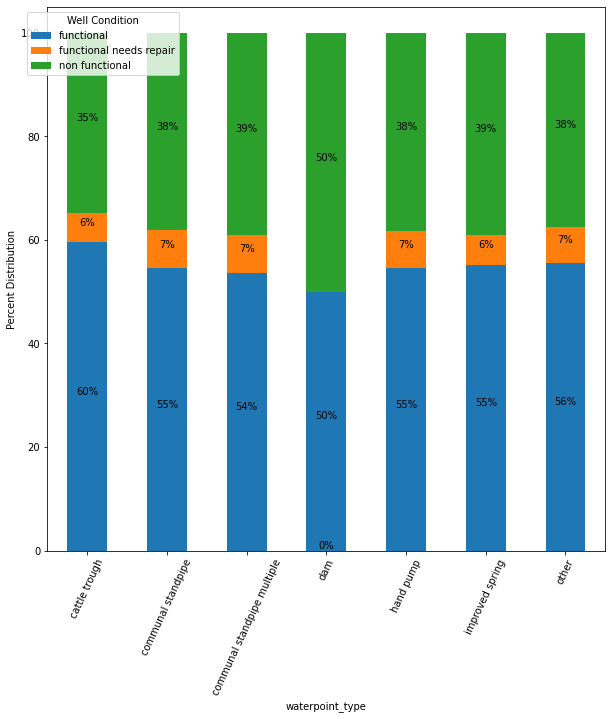

status_group,functional,functional needs repair,non functional
installer_new,,,
ces,51.323829,8.757637,39.918534
church,56.091371,7.741117,36.167513
community,54.574132,8.138801,37.287066
council,55.422794,6.158088,38.419118
danida,54.778029,7.072987,38.148984
dwe,53.906948,7.277850,38.815202
finw,57.575758,7.336523,35.087719
hesawa,57.142857,5.914468,36.942675
kkkt,58.634538,6.157965,35.207497


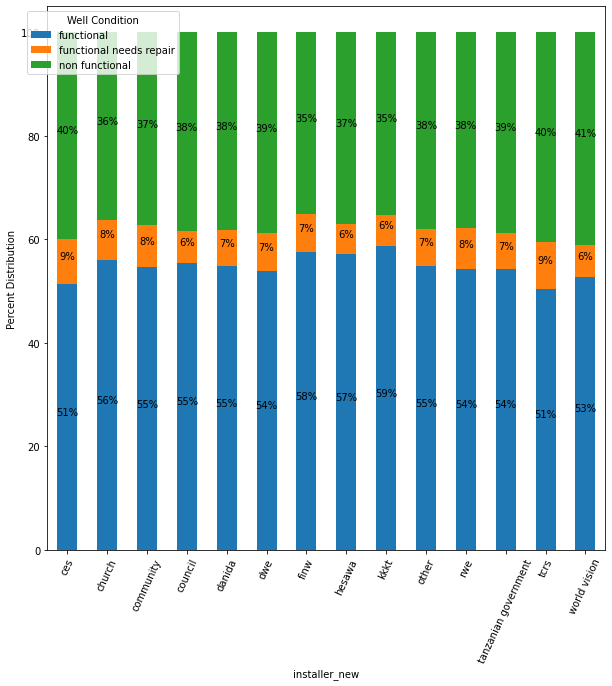

status_group,functional,functional needs repair,non functional
funder_new,,,
church,54.915254,7.627119,37.457627
danida,54.325956,7.364185,38.309859
dhv,54.892966,5.963303,39.143731
district council,55.322716,6.119028,38.558256
dwsp,54.224270,7.066052,38.709677
finw,57.119205,6.953642,35.927152
german group,51.919866,8.681135,39.398998
government,54.008609,7.452246,38.539144
hesawa,56.662870,7.004556,36.332574


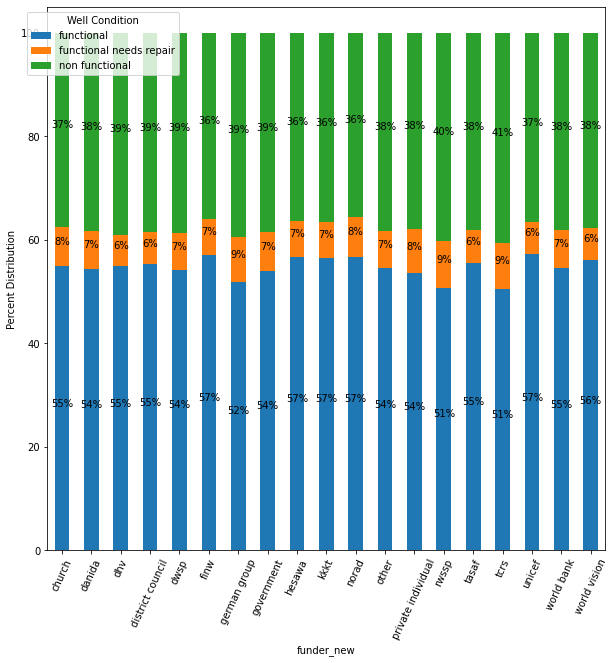

In [199]:
for column in visuals:
    ax= pd.crosstab(df_train[column], df_train['status_group']).apply(lambda r: r/r.sum()*100, axis=1)
    ax_1 = ax.plot.bar(figsize=(10,10),stacked=True, rot=0)
    display(ax)
    plt.legend(loc='upper center', bbox_to_anchor=(0.1, 1.0), title='Well Condition')
    plt.xlabel(column)
    plt.xticks(rotation=65)
    plt.ylabel('Percent Distribution')
    
    for rec in ax_1.patches:
        height = rec.get_height()
        ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')
    plt.show()

In [203]:
df_train['latitude'].value_counts(normalize=True, dropna = False)

-2.000000e-08    0.030574
-6.980122e+00    0.000042
-2.494546e+00    0.000042
-6.956746e+00    0.000042
-6.964258e+00    0.000042
                   ...   
-6.899767e+00    0.000021
-4.422470e+00    0.000021
-8.446126e+00    0.000021
-3.220441e+00    0.000021
-7.714786e+00    0.000021
Name: latitude, Length: 45996, dtype: float64

In [204]:
df_train['longitude'].value_counts(normalize=True, dropna = False)

0.000000     0.030574
37.314250    0.000042
32.984790    0.000042
39.105307    0.000042
39.095087    0.000042
               ...   
29.810473    0.000021
37.383938    0.000021
38.991929    0.000021
38.455444    0.000021
36.781854    0.000021
Name: longitude, Length: 45994, dtype: float64

In [205]:
df_visual = df_train[df_train.longitude != 0]

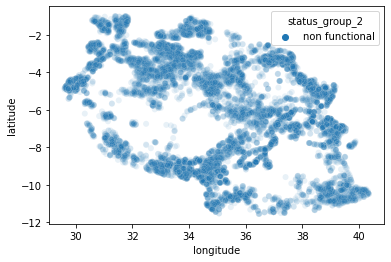

In [223]:
sns.scatterplot('longitude','latitude', data=df_visual[df_visual['status_group_2'] == 'non functional'], hue='status_group_2',alpha=0.1)

plt.show()

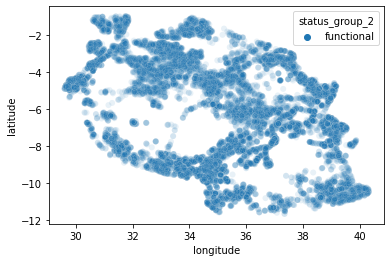

In [224]:
sns.scatterplot('longitude','latitude', data=df_visual[df_visual['status_group_2'] == 'functional'], hue='status_group_2',alpha=0.1)

plt.show()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

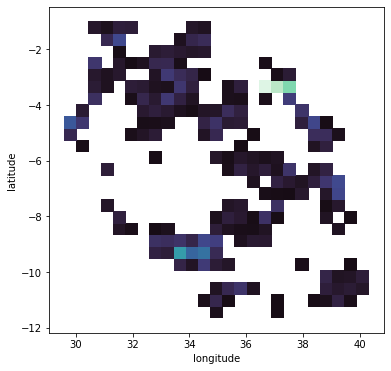

In [218]:
# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
#sns.scatterplot(x='longitude', y='latitude', s=5, color=".15",data=df_visual)
sns.histplot(x='longitude', y='latitude',
             bins=25, pthresh=.1, cmap="mako",
             data=df_visual[df_visual['status_group'] =='functional'])
#sns.kdeplot(x='longitude', y='latitude', levels=5, color="w", linewidths=1,data=df_visual)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

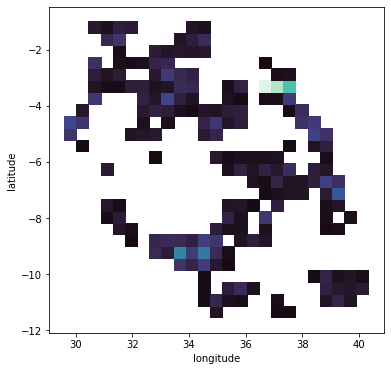

In [219]:
# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
#sns.scatterplot(x='longitude', y='latitude', s=5, color=".15",data=df_visual)
sns.histplot(x='longitude', y='latitude',
             bins=25, pthresh=.1, cmap="mako",
             data=df_visual[df_visual['status_group'] =='non functional'])
#sns.kdeplot(x='longitude', y='latitude', levels=5, color="w", linewidths=1,data=df_visual)

# Train Test Split

In [86]:
X=df_train.drop(columns = ['status_group']) # Features
y=df_train['status_group'] #Target

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [88]:
X_train

,id_left,amount_tsh,longitude,latitude,basin,region_code,district_code,lga,permit,construction_year,...,management_group,payment,quality_group,quantity,source_type,source_class,waterpoint_type,installer_new,funder_new,id_right
13863,46282,"(-1, 0]",39.198567,-7.564350,Rufiji,60,53,other,1,"(1985.0, 2005.0]",...,user-group,never pay,good,insufficient,shallow well,groundwater,hand pump,other,other,49235.0
52464,32809,"(20, 350000]",37.180087,-3.192072,Pangani,3,5,hai,1,"(1985.0, 2005.0]",...,user-group,other,good,enough,spring,groundwater,communal standpipe,ces,german group,68203.0
49573,33129,"(-1, 0]",35.420048,-8.418192,Rufiji,11,2,other,0,"(1985.0, 2005.0]",...,user-group,never pay,good,enough,shallow well,groundwater,hand pump,dwe,other,69545.0
46133,35725,"(20, 350000]",37.917789,-4.155432,Pangani,3,3,same,1,"(1985.0, 2005.0]",...,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,world vision,world vision,73372.0
1277,10355,"(-1, 0]",34.497217,-5.706788,Rufiji,13,3,other,0,"(1.0, 1985.0]",...,user-group,never pay,good,insufficient,borehole,groundwater,communal standpipe multiple,other,other,46247.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28267,16272,"(-1, 0]",34.376661,-8.697432,Rufiji,12,7,mbarali,1,NaN,...,user-group,never pay,colored,seasonal,river/lake,surface,communal standpipe,other,other,26284.0
48544,57986,"(0, 20]",39.366473,-10.875261,Ruvuma / Southern Coast,90,33,other,0,"(1985.0, 2005.0]",...,user-group,pay per bucket,good,insufficient,spring,groundwater,other,other,unicef,74211.0
6440,37180,"(-1, 0]",39.448854,-10.622765,Ruvuma / Southern Coast,9,4,other,1,"(1.0, 1985.0]",...,user-group,never pay,good,enough,borehole,groundwater,communal standpipe,finw,finw,26771.0
46755,47703,"(20, 350000]",34.794685,-9.032680,Rufiji,11,4,njombe,1,"(2005.0, 2015.0]",...,user-group,pay monthly,good,enough,spring,groundwater,communal standpipe,other,other,9824.0


In [89]:
X_train.shape

(33244, 22)

In [90]:
X_test.shape

(14248, 22)

# Encode Features

In [91]:
df_train.columns

Index(['id_left', 'amount_tsh', 'longitude', 'latitude', 'basin',
       'region_code', 'district_code', 'lga', 'permit', 'construction_year',
       'extraction_type_group', 'management', 'management_group', 'payment',
       'quality_group', 'quantity', 'source_type', 'source_class',
       'waterpoint_type', 'installer_new', 'funder_new', 'id_right',
       'status_group'],
      dtype='object')

In [92]:
col_names = list(df_train.columns)

In [93]:
col_names_ohe = col_names

In [94]:
remove_ohe = ['id_left','id_right','permit','status_group','longitude','latitude']

In [95]:
for ele in remove_ohe:
    if ele in col_names_ohe:
        col_names_ohe.remove(ele)
col_names_ohe

['amount_tsh',
 'basin',
 'region_code',
 'district_code',
 'lga',
 'construction_year',
 'extraction_type_group',
 'management',
 'management_group',
 'payment',
 'quality_group',
 'quantity',
 'source_type',
 'source_class',
 'waterpoint_type',
 'installer_new',
 'funder_new']

In [96]:
X_train[col_names] = X_train[col_names_ohe].astype('category')
X_test[col_names] = X_test[col_names_ohe].astype('category')

In [97]:
X_train_ohe = X_train[col_names_ohe]
X_test_ohe = X_test[col_names_ohe]

## X_train Encode

In [98]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33244 entries, 13863 to 30980
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id_left                33244 non-null  int64   
 1   amount_tsh             33244 non-null  category
 2   longitude              33244 non-null  float64 
 3   latitude               33244 non-null  float64 
 4   basin                  33244 non-null  category
 5   region_code            33244 non-null  category
 6   district_code          33244 non-null  category
 7   lga                    33244 non-null  category
 8   permit                 33244 non-null  int64   
 9   construction_year      21674 non-null  category
 10  extraction_type_group  33244 non-null  category
 11  management             33244 non-null  category
 12  management_group       33244 non-null  category
 13  payment                33244 non-null  category
 14  quality_group          33244 non-n

Change Sci kit learn OHE set sparse to false set handle errors to ignore drop first equals if binary

In [99]:
enc = OneHotEncoder(handle_unknown='ignore',sparse=False)

In [100]:
enc.fit(X_train_ohe) 

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [101]:
enc.categories_

[array([Interval(-1, 0, closed='right'), Interval(0, 20, closed='right'),
        Interval(20, 350000, closed='right')], dtype=object),
 array(['Internal', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika',
        'Lake Victoria', 'Pangani', 'Rufiji', 'Ruvuma / Southern Coast',
        'Wami / Ruvu'], dtype=object),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 24, 40, 60, 80, 90, 99]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 13, 23, 30, 33, 43, 53, 60, 62,
        63, 67, 80]),
 array(['arusha rural', 'bagamoyo', 'bariadi', 'hai', 'iringa rural',
        'kahama', 'karagwe', 'kasulu', 'kibondo', 'kigoma rural',
        'kilombero', 'kilosa', 'kwimba', 'kyela', 'lushoto', 'magu',
        'makete', 'maswa', 'mbarali', 'mbinga', 'mbozi', 'meru',
        'moshi rural', 'mpanda', 'mvomero', 'namtumbo', 'ngara', 'njombe',
        'other', 'rombo', 'rungwe', 'same', 'serengeti', 'singida rural',
        'songea rural', 'ulanga'], dtype=o

In [102]:
X_train2 = enc.transform(X_train_ohe)

In [103]:
X_train2.shape

(33244, 197)

In [104]:
enc.get_feature_names()
column_name = enc.get_feature_names()
one_hot_encoded_frame =  pd.DataFrame(X_train2, columns= column_name)

In [105]:
X_train = one_hot_encoded_frame.reset_index(drop=True).merge(X_train.reset_index(drop=True), left_index=True, right_index=True)


In [106]:
X_train.drop(col_names_ohe, axis=1, inplace=True)
X_train

,"x0_(-1, 0]","x0_(0, 20]","x0_(20, 350000]",x1_Internal,x1_Lake Nyasa,x1_Lake Rukwa,x1_Lake Tanganyika,x1_Lake Victoria,x1_Pangani,x1_Rufiji,...,x16_tasaf,x16_tcrs,x16_unicef,x16_world bank,x16_world vision,id_left,longitude,latitude,permit,id_right
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,46282,39.198567,-7.564350,1,49235.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,32809,37.180087,-3.192072,1,68203.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,33129,35.420048,-8.418192,0,69545.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,35725,37.917789,-4.155432,1,73372.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,10355,34.497217,-5.706788,0,46247.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33239,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,16272,34.376661,-8.697432,1,26284.0
33240,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,57986,39.366473,-10.875261,0,74211.0
33241,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,37180,39.448854,-10.622765,1,26771.0
33242,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,47703,34.794685,-9.032680,1,9824.0


In [107]:
del X_train['id_left']
del X_train['id_right']

In [108]:
X_train

,"x0_(-1, 0]","x0_(0, 20]","x0_(20, 350000]",x1_Internal,x1_Lake Nyasa,x1_Lake Rukwa,x1_Lake Tanganyika,x1_Lake Victoria,x1_Pangani,x1_Rufiji,...,x16_private individual,x16_rwssp,x16_tasaf,x16_tcrs,x16_unicef,x16_world bank,x16_world vision,longitude,latitude,permit
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.198567,-7.564350,1
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.180087,-3.192072,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.420048,-8.418192,0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,37.917789,-4.155432,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.497217,-5.706788,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33239,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.376661,-8.697432,1
33240,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39.366473,-10.875261,0
33241,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.448854,-10.622765,1
33242,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.794685,-9.032680,1


## X_test Encode

In [109]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14248 entries, 50633 to 30177
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id_left                14248 non-null  int64   
 1   amount_tsh             14248 non-null  category
 2   longitude              14248 non-null  float64 
 3   latitude               14248 non-null  float64 
 4   basin                  14248 non-null  category
 5   region_code            14248 non-null  category
 6   district_code          14248 non-null  category
 7   lga                    14248 non-null  category
 8   permit                 14248 non-null  int64   
 9   construction_year      9298 non-null   category
 10  extraction_type_group  14248 non-null  category
 11  management             14248 non-null  category
 12  management_group       14248 non-null  category
 13  payment                14248 non-null  category
 14  quality_group          14248 non-n

In [110]:
enc.categories_

[array([Interval(-1, 0, closed='right'), Interval(0, 20, closed='right'),
        Interval(20, 350000, closed='right')], dtype=object),
 array(['Internal', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika',
        'Lake Victoria', 'Pangani', 'Rufiji', 'Ruvuma / Southern Coast',
        'Wami / Ruvu'], dtype=object),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 24, 40, 60, 80, 90, 99]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 13, 23, 30, 33, 43, 53, 60, 62,
        63, 67, 80]),
 array(['arusha rural', 'bagamoyo', 'bariadi', 'hai', 'iringa rural',
        'kahama', 'karagwe', 'kasulu', 'kibondo', 'kigoma rural',
        'kilombero', 'kilosa', 'kwimba', 'kyela', 'lushoto', 'magu',
        'makete', 'maswa', 'mbarali', 'mbinga', 'mbozi', 'meru',
        'moshi rural', 'mpanda', 'mvomero', 'namtumbo', 'ngara', 'njombe',
        'other', 'rombo', 'rungwe', 'same', 'serengeti', 'singida rural',
        'songea rural', 'ulanga'], dtype=o

In [111]:
X_test2 = enc.transform(X_test_ohe)

In [112]:
X_test2.shape

(14248, 197)

In [113]:
enc.get_feature_names()
column_name = enc.get_feature_names()
one_hot_encoded_frame =  pd.DataFrame(X_test2, columns= column_name)

In [114]:
X_test = one_hot_encoded_frame.reset_index(drop=True).merge(X_test.reset_index(drop=True), left_index=True, right_index=True)


In [115]:
X_test.drop(col_names_ohe, axis=1, inplace=True)
X_test

,"x0_(-1, 0]","x0_(0, 20]","x0_(20, 350000]",x1_Internal,x1_Lake Nyasa,x1_Lake Rukwa,x1_Lake Tanganyika,x1_Lake Victoria,x1_Pangani,x1_Rufiji,...,x16_tasaf,x16_tcrs,x16_unicef,x16_world bank,x16_world vision,id_left,longitude,latitude,permit,id_right
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,21684,32.029644,-3.356948,1,13741.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,14202,33.918430,-9.437514,1,45699.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7755,32.728018,-8.861211,0,48671.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,56771,37.548653,-6.252355,1,73381.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,14050,29.823993,-4.878173,1,36024.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,14133,30.712539,-1.330670,1,3508.0
14244,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9639,33.383450,-3.783168,0,62489.0
14245,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,58622,34.187547,-3.178968,0,59180.0
14246,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,33620,35.652858,-8.106353,1,52289.0


In [116]:
del X_test['id_left']
del X_test['id_right']

In [117]:
X_test

,"x0_(-1, 0]","x0_(0, 20]","x0_(20, 350000]",x1_Internal,x1_Lake Nyasa,x1_Lake Rukwa,x1_Lake Tanganyika,x1_Lake Victoria,x1_Pangani,x1_Rufiji,...,x16_private individual,x16_rwssp,x16_tasaf,x16_tcrs,x16_unicef,x16_world bank,x16_world vision,longitude,latitude,permit
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.029644,-3.356948,1
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.918430,-9.437514,1
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.728018,-8.861211,0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,37.548653,-6.252355,1
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.823993,-4.878173,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.712539,-1.330670,1
14244,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.383450,-3.783168,0
14245,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.187547,-3.178968,0
14246,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.652858,-8.106353,1


In [118]:
X_train.shape

(33244, 200)

In [119]:
X_test.shape

(14248, 200)

## Delete 'other' columns OHE

For Text data which was too low incidence to make its own group we consolidated it in 'other' groups. This is noisy data that should be deleted.

### Delete Other Train

In [120]:
X_train

,"x0_(-1, 0]","x0_(0, 20]","x0_(20, 350000]",x1_Internal,x1_Lake Nyasa,x1_Lake Rukwa,x1_Lake Tanganyika,x1_Lake Victoria,x1_Pangani,x1_Rufiji,...,x16_private individual,x16_rwssp,x16_tasaf,x16_tcrs,x16_unicef,x16_world bank,x16_world vision,longitude,latitude,permit
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.198567,-7.564350,1
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.180087,-3.192072,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.420048,-8.418192,0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,37.917789,-4.155432,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.497217,-5.706788,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33239,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.376661,-8.697432,1
33240,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39.366473,-10.875261,0
33241,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.448854,-10.622765,1
33242,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.794685,-9.032680,1


In [121]:
other_cols = [col for col in X_train.columns if 'other' in col]
other_cols

['x4_other',
 'x6_other',
 'x6_other handpump',
 'x6_other motorpump',
 'x7_other',
 'x7_other - school',
 'x8_other',
 'x9_other',
 'x12_other',
 'x14_other',
 'x15_other',
 'x16_other']

In [122]:
X_train = X_train.drop(other_cols, axis=1)
X_train.columns

Index(['x0_(-1, 0]', 'x0_(0, 20]', 'x0_(20, 350000]', 'x1_Internal',
       'x1_Lake Nyasa', 'x1_Lake Rukwa', 'x1_Lake Tanganyika',
       'x1_Lake Victoria', 'x1_Pangani', 'x1_Rufiji',
       ...
       'x16_private individual', 'x16_rwssp', 'x16_tasaf', 'x16_tcrs',
       'x16_unicef', 'x16_world bank', 'x16_world vision', 'longitude',
       'latitude', 'permit'],
      dtype='object', length=188)

### Delete Other Test

In [123]:
X_test = X_test.drop(other_cols, axis=1)
X_test.columns

Index(['x0_(-1, 0]', 'x0_(0, 20]', 'x0_(20, 350000]', 'x1_Internal',
       'x1_Lake Nyasa', 'x1_Lake Rukwa', 'x1_Lake Tanganyika',
       'x1_Lake Victoria', 'x1_Pangani', 'x1_Rufiji',
       ...
       'x16_private individual', 'x16_rwssp', 'x16_tasaf', 'x16_tcrs',
       'x16_unicef', 'x16_world bank', 'x16_world vision', 'longitude',
       'latitude', 'permit'],
      dtype='object', length=188)

In [124]:
other_cols_test = [col for col in X_test.columns if 'other' in col]
other_cols_test

[]

### Label Encode Target

In [125]:
di = {0: 0, 'functional': 1, 'non functional': 2, 'functional needs repair':3 }
y_train.replace(di, inplace=True)

In [126]:
di = {0: 0, 'functional': 1, 'non functional': 2, 'functional needs repair':3 }
y_test.replace(di, inplace=True)

# Model Development

## Random Forest Classifier

In [127]:
# Instantiate and fit the RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=10,class_weight='balanced')
rfc.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=10)

In [128]:
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
y_pred = rfc.predict(X_test)
y_pred_train = rfc.predict(X_train)
prediction_end = time.perf_counter()
acc_rfc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 48.05
Time consumed for training: 1.057 seconds
Time consumed for prediction: 0.24293 seconds


In [129]:
print(metrics.classification_report(y_test, y_pred, labels=[1,2,3]))

              precision    recall  f1-score   support

           1       0.55      0.65      0.59      7788
           2       0.39      0.32      0.35      5433
           3       0.10      0.06      0.07      1027

    accuracy                           0.48     14248
   macro avg       0.35      0.34      0.34     14248
weighted avg       0.46      0.48      0.47     14248



### Check for Overfit

In [130]:
# View confusion matrix for train data and predictions
confusion_matrix(y_train, y_pred_train)

array([[17717,   294,   113],
       [  865, 11780,    70],
       [  207,   116,  2082]])

In [131]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred)

array([[5026, 2429,  333],
       [3449, 1760,  224],
       [ 638,  329,   60]])

In [132]:
rfc_training_preds = rfc.predict(X_train)
rfc_training_accuracy = accuracy_score(y_train, rfc_training_preds)

rfc_val_preds = rfc.predict(X_test) # y_hat
rfc_val_accuracy = accuracy_score(y_test, rfc_val_preds)
print(rfc_training_accuracy)
print(rfc_val_accuracy)

0.9499157742750571
0.48048848961257723


Because we are looking for the minority class accuracy scores are not the best measure overfit.

Lets take a look at other metrics in the classification report.

In [133]:
print(metrics.classification_report(y_train, y_pred_train, labels=[1,2,3]))

              precision    recall  f1-score   support

           1       0.94      0.98      0.96     18124
           2       0.97      0.93      0.95     12715
           3       0.92      0.87      0.89      2405

    accuracy                           0.95     33244
   macro avg       0.94      0.92      0.93     33244
weighted avg       0.95      0.95      0.95     33244



In [134]:
print(metrics.classification_report(y_test, y_pred, labels=[1,2,3]))

              precision    recall  f1-score   support

           1       0.55      0.65      0.59      7788
           2       0.39      0.32      0.35      5433
           3       0.10      0.06      0.07      1027

    accuracy                           0.48     14248
   macro avg       0.35      0.34      0.34     14248
weighted avg       0.46      0.48      0.47     14248



Add labels so it's clear which class is being described

### Feature Importance

In [135]:
# create list so that random forest model important features are named
rfc_columns = list(X_train.columns)

<AxesSubplot:>

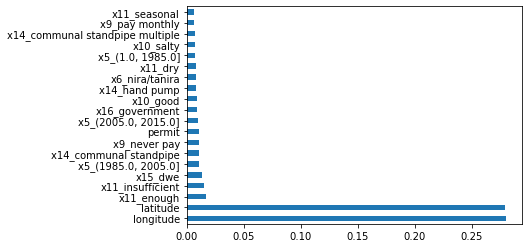

In [136]:
feat_importances = pd.Series(rfc.feature_importances_, index = rfc_columns)
feat_importances.nlargest(20).plot(kind='barh')

### Model reiteration - parameter tuning

Don't set anything to random, choose the ones that you want, don't use trunc norm, set all of them as lists,  then you can use settings like log/auto or floats for percentage of features.

In [137]:
model_params = {
    # number of trees
    'n_estimators': [5,10,20,50,100,200],
    # number of max features
    'max_features': [10,15,20,50,100],
    # max number of levels in each decision tre
    'max_depth': [5,10,15],
    'min_samples_split' : [100,1000]
}

In [138]:
# Instantiate and fit the RandomForestClassifier
rfc=RandomForestClassifier(class_weight='balanced')
rfc = RandomizedSearchCV(rfc,model_params, n_iter=10, cv=3, random_state=1)
rfc.fit(X_train,y_train)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   param_distributions={'max_depth': [5, 10, 15],
                                        'max_features': [10, 15, 20, 50, 100],
                                        'min_samples_split': [100, 1000],
                                        'n_estimators': [5, 10, 20, 50, 100,
                                                         200]},
                   random_state=1)

In [139]:
print(rfc.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 50, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 100, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [140]:
print(metrics.classification_report(y_train, y_pred_train, labels=[1,2,3]))

              precision    recall  f1-score   support

           1       0.94      0.98      0.96     18124
           2       0.97      0.93      0.95     12715
           3       0.92      0.87      0.89      2405

    accuracy                           0.95     33244
   macro avg       0.94      0.92      0.93     33244
weighted avg       0.95      0.95      0.95     33244



In [141]:
print(metrics.classification_report(y_test, y_pred, labels=[1,2,3]))

              precision    recall  f1-score   support

           1       0.55      0.65      0.59      7788
           2       0.39      0.32      0.35      5433
           3       0.10      0.06      0.07      1027

    accuracy                           0.48     14248
   macro avg       0.35      0.34      0.34     14248
weighted avg       0.46      0.48      0.47     14248



## Gradient Boosting Classifier

In [142]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)
y_pred_train = gb_clf.predict(X_train)

# print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
# print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

In [143]:
print(metrics.classification_report(y_test, y_pred, labels=[1,2,3]))

              precision    recall  f1-score   support

           1       0.55      0.99      0.70      7788
           2       0.34      0.01      0.02      5433
           3       0.50      0.00      0.00      1027

    accuracy                           0.54     14248
   macro avg       0.46      0.33      0.24     14248
weighted avg       0.46      0.54      0.39     14248



This model did worse at finding the minority class

### Check for Overfit

In [144]:
# View confusion matrix for train data and predictions
confusion_matrix(y_train, y_pred_train)

array([[18074,    50,     0],
       [12410,   305,     0],
       [ 2360,    32,    13]])

In [145]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred)

array([[7706,   82,    0],
       [5386,   46,    1],
       [1019,    7,    1]])

In [146]:
print(metrics.classification_report(y_train, y_pred_train, labels=[1,2,3]))

              precision    recall  f1-score   support

           1       0.55      1.00      0.71     18124
           2       0.79      0.02      0.05     12715
           3       1.00      0.01      0.01      2405

    accuracy                           0.55     33244
   macro avg       0.78      0.34      0.26     33244
weighted avg       0.67      0.55      0.41     33244



In [147]:
print(metrics.classification_report(y_test, y_pred, labels=[1,2,3]))

              precision    recall  f1-score   support

           1       0.55      0.99      0.70      7788
           2       0.34      0.01      0.02      5433
           3       0.50      0.00      0.00      1027

    accuracy                           0.54     14248
   macro avg       0.46      0.33      0.24     14248
weighted avg       0.46      0.54      0.39     14248



### Model reiteration - parameter tuning

In [148]:
model_params = {
    # number of boosting stages
    'n_estimators': [5,10,20,50,100,200],
    # number of max features
    'max_features': [10,15,20,50,100],
    # Learning rate
    'learning_rate':[.25,.5,.75,1],
    #The minimum number of samples required to split an internal node
    'min_samples_split' : [100,1000]
}

In [149]:
gb_clf = RandomizedSearchCV(gb_clf,model_params, n_iter=10, cv=3, random_state=1)
gb_clf.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(),
                   param_distributions={'learning_rate': [0.25, 0.5, 0.75, 1],
                                        'max_features': [10, 15, 20, 50, 100],
                                        'min_samples_split': [100, 1000],
                                        'n_estimators': [5, 10, 20, 50, 100,
                                                         200]},
                   random_state=1)

In [150]:
print(metrics.classification_report(y_train, y_pred_train, labels=[1,2,3]))

              precision    recall  f1-score   support

           1       0.55      1.00      0.71     18124
           2       0.79      0.02      0.05     12715
           3       1.00      0.01      0.01      2405

    accuracy                           0.55     33244
   macro avg       0.78      0.34      0.26     33244
weighted avg       0.67      0.55      0.41     33244



In [151]:
print(metrics.classification_report(y_test, y_pred, labels=[1,2,3]))

              precision    recall  f1-score   support

           1       0.55      0.99      0.70      7788
           2       0.34      0.01      0.02      5433
           3       0.50      0.00      0.00      1027

    accuracy                           0.54     14248
   macro avg       0.46      0.33      0.24     14248
weighted avg       0.46      0.54      0.39     14248



In [152]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.545
Accuracy score (validation): 0.546
Learning rate:  0.075
Accuracy score (training): 0.546
Accuracy score (validation): 0.546
Learning rate:  0.1
Accuracy score (training): 0.547
Accuracy score (validation): 0.546
Learning rate:  0.25
Accuracy score (training): 0.550
Accuracy score (validation): 0.545
Learning rate:  0.5
Accuracy score (training): 0.558
Accuracy score (validation): 0.541
Learning rate:  0.75
Accuracy score (training): 0.558
Accuracy score (validation): 0.539
Learning rate:  1
Accuracy score (training): 0.561
Accuracy score (validation): 0.538


## Logistic Regression

### unbalanced

In [153]:
# Logistic model
log_clf = LogisticRegression(random_state=123, multi_class='multinomial', solver='newton-cg')
log_model = log_clf.fit(X_train, y_train)
log_training_preds = log_clf.predict(X_train)
log_training_accuracy = accuracy_score(y_train, log_training_preds)
log_val_preds = log_clf.predict(X_test) # y_hat
log_val_accuracy = accuracy_score(y_test, log_val_preds)

In [154]:
#Confusion matrix for Logistic Regression
log_matrix = confusion_matrix(y_test, log_val_preds)
print('Confusion Matrix:\n', log_matrix)

Confusion Matrix:
 [[7677  111    0]
 [5361   72    0]
 [1009   18    0]]


In [155]:
print(log_training_accuracy)
print(log_val_accuracy)

0.5455119720851883
0.5438658057271196


In [156]:
y_pred = log_model.predict(X_test)

In [157]:
print(metrics.classification_report(y_test, y_pred, labels=[1,2,3]))

              precision    recall  f1-score   support

           1       0.55      0.99      0.70      7788
           2       0.36      0.01      0.03      5433
           3       0.00      0.00      0.00      1027

    accuracy                           0.54     14248
   macro avg       0.30      0.33      0.24     14248
weighted avg       0.44      0.54      0.39     14248



### balanced

In [158]:
# Logistic model
log_clf = LogisticRegression(multi_class='multinomial', solver='newton-cg',class_weight='balanced')
log_model = log_clf.fit(X_train, y_train)
y_pred_train = log_model.predict(X_train)
y_pred = log_model.predict(X_test)
log_training_accuracy = accuracy_score(y_train, y_pred_train)
log_val_accuracy = accuracy_score(y_test, y_pred)

In [159]:
#Confusion matrix for Logistic Regression
log_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', log_matrix)

Confusion Matrix:
 [[2546 2399 2843]
 [1735 1657 2041]
 [ 347  297  383]]


In [160]:
print(log_training_accuracy)
print(log_val_accuracy)

0.3494465166646613
0.32186973610331276


In [161]:
print(metrics.classification_report(y_test, y_pred, labels=[1,2,3]))

              precision    recall  f1-score   support

           1       0.55      0.33      0.41      7788
           2       0.38      0.30      0.34      5433
           3       0.07      0.37      0.12      1027

    accuracy                           0.32     14248
   macro avg       0.33      0.33      0.29     14248
weighted avg       0.45      0.32      0.36     14248



### Check for Overfit

In [162]:
# View confusion matrix for train data and predictions
confusion_matrix(y_train, y_pred_train)

array([[6334, 5293, 6497],
       [3973, 4206, 4536],
       [ 686,  642, 1077]])

In [163]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred)

array([[2546, 2399, 2843],
       [1735, 1657, 2041],
       [ 347,  297,  383]])

In [164]:
print(metrics.classification_report(y_train, y_pred_train, labels=[1,2,3]))

              precision    recall  f1-score   support

           1       0.58      0.35      0.44     18124
           2       0.41      0.33      0.37     12715
           3       0.09      0.45      0.15      2405

    accuracy                           0.35     33244
   macro avg       0.36      0.38      0.32     33244
weighted avg       0.48      0.35      0.39     33244



In [165]:
print(metrics.classification_report(y_test, y_pred, labels=[1,2,3]))

              precision    recall  f1-score   support

           1       0.55      0.33      0.41      7788
           2       0.38      0.30      0.34      5433
           3       0.07      0.37      0.12      1027

    accuracy                           0.32     14248
   macro avg       0.33      0.33      0.29     14248
weighted avg       0.45      0.32      0.36     14248



### Model reiteration - parameter tuning

In [166]:
# Logistic model
log_clf = LogisticRegression(multi_class='multinomial', class_weight='balanced')
log_model = log_clf.fit(X_train, y_train)
y_pred_train = log_model.predict(X_train)
y_pred = log_model.predict(X_test)
log_training_accuracy = accuracy_score(y_train, y_pred_train)
log_val_accuracy = accuracy_score(y_test, y_pred)

In [167]:
model_params = {
    #Algorithm to use in the optimization problem
    'solver': ['newton-cg', 'sag', 'saga','lbfgs']
}

In [168]:
# Instantiate and fit the LogisticReg Model
log_clf = LogisticRegression(multi_class='multinomial', class_weight='balanced')
log_clf = RandomizedSearchCV(log_clf,model_params, n_iter=10, cv=3)
log_clf.fit(X_train,y_train)

RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(class_weight='balanced',
                                                multi_class='multinomial'),
                   param_distributions={'solver': ['newton-cg', 'sag', 'saga',
                                                   'lbfgs']})

In [169]:
print(log_clf.best_estimator_.get_params())

{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'sag', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [170]:
print(metrics.classification_report(y_train, y_pred_train, labels=[1,2,3]))

              precision    recall  f1-score   support

           1       0.57      0.30      0.40     18124
           2       0.41      0.35      0.38     12715
           3       0.09      0.46      0.15      2405

    accuracy                           0.33     33244
   macro avg       0.36      0.37      0.31     33244
weighted avg       0.47      0.33      0.37     33244



In [171]:
print(metrics.classification_report(y_test, y_pred, labels=[1,2,3]))

              precision    recall  f1-score   support

           1       0.54      0.28      0.37      7788
           2       0.38      0.33      0.35      5433
           3       0.07      0.38      0.12      1027

    accuracy                           0.30     14248
   macro avg       0.33      0.33      0.28     14248
weighted avg       0.44      0.30      0.34     14248



# Conclusions

Most Important Factors in water pump functionality:
- geographic location
- Water Quantity
- Construction Year
- Whether it was permited
- Who funded the pump
- Who installed the pump

- Installing pumps in low water quantity areas leads to more broken pumps
- Permited pumps were more likely to be functional.
- Pumps older than 1985 have poor functionality

# Business Recommendations

- Expand permiting system. Waterpoints which were permited were more likely to bee functional.
- Areas which already have low water quantities need more maintenance of their pumps
- Add a data feature for best guess of when pump lost functionality
    - This can be used to better predict lifetime of pumps
- Review all pumps older than 1985 as these are more likely to be broken


# Future Work

Things to work on if more time:

- Exploration of other numerical features such as gps height and population
    - when we examined a boxplot of these features they appeared not to affect the target.
    - However we may have removed these prematurely and should examine the effect of these variables on the model
        once log normalized.
- Look more closely at pump functionality by geographic region. 
    - The latitude and longitude of the waterpoint were the strongest indicator of pump functionality
    - Since this is by far our best feature further investigation is warranted to identify which regions are struggling the most with water supply
    
    
    
    
    
    
    
    
    
    
    
    .